In [1]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import EMBEDCVAE
from lataq.exp_dict import EXPERIMENT_INFO

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=500)
plt.rcParams['figure.figsize'] = (5, 5)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

In [2]:
PARAMS = {
    'EPOCHS': 50,                                      #TOTAL TRAINING EPOCHS
    'N_PRE_EPOCHS': 45,                                #EPOCHS OF PRETRAINING WITHOUT LANDMARK LOSS
    #'DATA_DIR': '../../lataq_reproduce/data',          #DIRECTORY WHERE THE DATA IS STORED
    #'DATA': 'pancreas',                                #DATA USED FOR THE EXPERIMENT
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_landmark_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    'LABELED_LOSS_METRIC': 'dist',           
    'UNLABELED_LOSS_METRIC': 'dist',
    'LATENT_DIM': 25,
    'ALPHA_EPOCH_ANNEAL': 1e3,
    'CLUSTERING_RES': 2,
    'HIDDEN_LAYERS': 5,
    'ETA': 1,
}

In [3]:
DATA_DIR = '../data'
adata_healthy = sc.read(
    f'{DATA_DIR}/haniffa_healthy_obsmProt.h5ad'
)
adata_disease = sc.read(
    f'{DATA_DIR}/haniffa_disease_obsmProt.h5ad'
)
adata = adata_healthy.concatenate(adata_disease)

In [4]:
pd.crosstab(adata.obs['patient_id'], adata.obs['initial_clustering'])

initial_clustering  B_cell   CD4   CD8  CD14  CD16  DCs  HSC  Lymph_prolif  \
patient_id                                                                   
AP1                    142  2165   518   655    94   27   24            32   
AP10                   388  1812   636    64    16    4    5            21   
AP11                   522  2353  1460  4467   714  119   17            43   
AP12                  1117  1908  1352  1140    77    5   13            22   
AP2                    149  3276   523   256    77    5   12            16   
...                    ...   ...   ...   ...   ...  ...  ...           ...   
newcastle21v2           38  1595   861  1998   412   86   34            47   
newcastle49            151  1726   523  2937   677  105  527            88   
newcastle59            126   274   697  2290   622   26   23            24   
newcastle65            131  2383  1221   399   240   92    7            31   
newcastle74            531   910  2423   572   263  124   21            23   

initial_clustering  MAIT  Mono_prolif  NK_16hi  NK_56hi  Plasmablast  \
patient_id                                                             
AP1                   22            0      444       36           67   
AP10                  68            0      190       35          156   
AP11                  76            1      614       87           88   
AP12                 138            1     2154      228           31   
AP2                   29            0      105       26           11   
...                  ...          ...      ...      ...          ...   
newcastle21v2         46            0     1483       93           18   
newcastle49           38           92      324       94           42   
newcastle59           55            2      534      122           21   
newcastle65          119            0      552      100            4   
newcastle74          147            0     1402      105            9   

initial_clustering  Platelets  RBC  Treg  gdT  pDC  
patient_id                                          
AP1                        36   24   173   29    6  
AP10                       28   18   162    8    5  
AP11                       95    4   219   27   15  
AP12                      109   36   188   50    5  
AP2                        36    2   214   23    0  
...                       ...  ...   ...  ...  ...  
newcastle21v2             260    0   179   97   53  
newcastle49               250    6   179   98  375  
newcastle59                71    1    43   29  136  
newcastle65                34    1   181  121   39  
newcastle74                55    0    87  218   42  

[130 rows x 18 columns]

In [5]:
condition_key = 'patient_id'
cell_type_key = ["initial_clustering"]
adata = adata[adata.obs[cell_type_key[0]] != 'Mono_prolif']
patients = pd.Series(adata.obs.patient_id.unique())
reference = patients[~patients.str.contains('newcastle')]
query = patients[~patients.isin(reference)]
adata.obs['query'] = adata.obs[condition_key].isin(query).astype('category')

Trying to set attribute `.obs` of view, copying.


In [6]:
adata_tmp = adata.copy()
sc.pp.normalize_total(adata_tmp)
sc.pp.log1p(adata_tmp)
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=4000)
adata.var = adata_tmp.var
adata = adata[:, adata.var['highly_variable']]
source_adata = adata[adata.obs[condition_key].isin(reference)].copy()
target_adata = adata[adata.obs[condition_key].isin(query)].copy()

In [7]:
query

0        newcastle65
10       newcastle74
34       newcastle20
46       newcastle21
53       newcastle59
56       newcastle49
62     newcastle21v2
65    newcastle004v2
dtype: object

In [8]:
source_adata.X

<597827x4000 sparse matrix of type '<class 'numpy.float32'>'
	with 89799604 stored elements in Compressed Sparse Row format>

In [9]:
target_adata

AnnData object with n_obs × n_vars = 48892 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'query'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'protein_expression'

In [10]:
lataq_model = EMBEDCVAE(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128]*int(PARAMS['HIDDEN_LAYERS']),
    latent_dim=PARAMS['LATENT_DIM'],
)

Embedding dictionary:
 	Num conditions: 122
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Hidden Layer 3 in/out: 128 128
	Hidden Layer 4 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Hidden Layer 3 in/out: 128 128
	Hidden Layer 4 in/out: 128 128
	Output Layer in/out:  128 4000 



In [11]:
lataq_model.train(
    n_epochs=PARAMS['EPOCHS'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    eta=PARAMS['ETA'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
    best_reload=False,
)

loaders init
loaders init done
457.2576494216919
 |████████████████████| 100.0%  - val_loss: 521.2627431755 - val_trvae_loss: 517.2049760737 - val_landmark_loss: 4.0577689670 - val_labeled_loss: 4.0577689670
Saving best state of network...
Best State was in Epoch 48


In [12]:
lataq_model.save('haniffa/', overwrite=True)

In [13]:
data_latent = lataq_model.get_latent(
    x=source_adata.X.A,
    c=source_adata.obs[condition_key]
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs = source_adata.obs

In [14]:
adata_latent.write('haniffa_latent.h5ad')

... storing 'sample_id' as categorical
... storing 'full_clustering' as categorical
... storing 'Resample' as categorical
... storing 'Collection_Day' as categorical
... storing 'Age_interval' as categorical
... storing 'Swab_result' as categorical
... storing 'Status' as categorical
... storing 'Smoker' as categorical
... storing 'Status_on_day_collection' as categorical
... storing 'Status_on_day_collection_summary' as categorical
... storing 'Days_from_onset' as categorical
... storing 'Site' as categorical
... storing 'time_after_LPS' as categorical
... storing 'Worst_Clinical_Status' as categorical
... storing 'Outcome' as categorical
... storing 'patient_id' as categorical


In [15]:
lataq_query = EMBEDCVAE.load_query_data(
    adata=target_adata,
    reference_model='haniffa/',
    labeled_indices=[],
)

AnnData object with n_obs × n_vars = 48892 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'query'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'protein_expression'
Embedding dictionary:
 	Num conditions: 130
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Hidden Layer 3 in/out: 128 128
	Hidden Layer 4 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Hidd

In [16]:
lataq_query.train(
    n_epochs=PARAMS['EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    eta=PARAMS['ETA'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
    best_reload=False,
)

loaders init
loaders init done
2.9970932006835938
 |██████████████████--| 90.0%  - val_loss: 594.3125985953 - val_trvae_loss: 594.3125985953
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 36 clusters.
 |████████████████████| 100.0%  - val_loss: 593.3238353240 - val_trvae_loss: 593.3237523788 - val_landmark_loss: 0.0000891862 - val_unlabeled_loss: 0.0891861940
Saving best state of network...
Best State was in Epoch 46


In [17]:
data_latent = lataq_query.get_latent(
    x=adata.X.A,
    c=adata.obs[condition_key]
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs = adata.obs
adata_latent.write('haniffa_latent_wquery.h5ad')

Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'full_clustering' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Resample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Collection_Day' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Age_interval' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Swab_result' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Status' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Smoker' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Status_on_day_collection' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Status_on_day_collection_summary' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Days_from_o

In [18]:
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    ['query']
)
print(cond)

patient_id
MH8919226         False
MH8919333         False
MH8919332         False
MH8919227         False
MH8919283         False
                  ...  
newcastle21        True
newcastle59        True
newcastle49        True
newcastle21v2      True
newcastle004v2     True
Name: query, Length: 130, dtype: category
Categories (2, object): [False, True]


/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


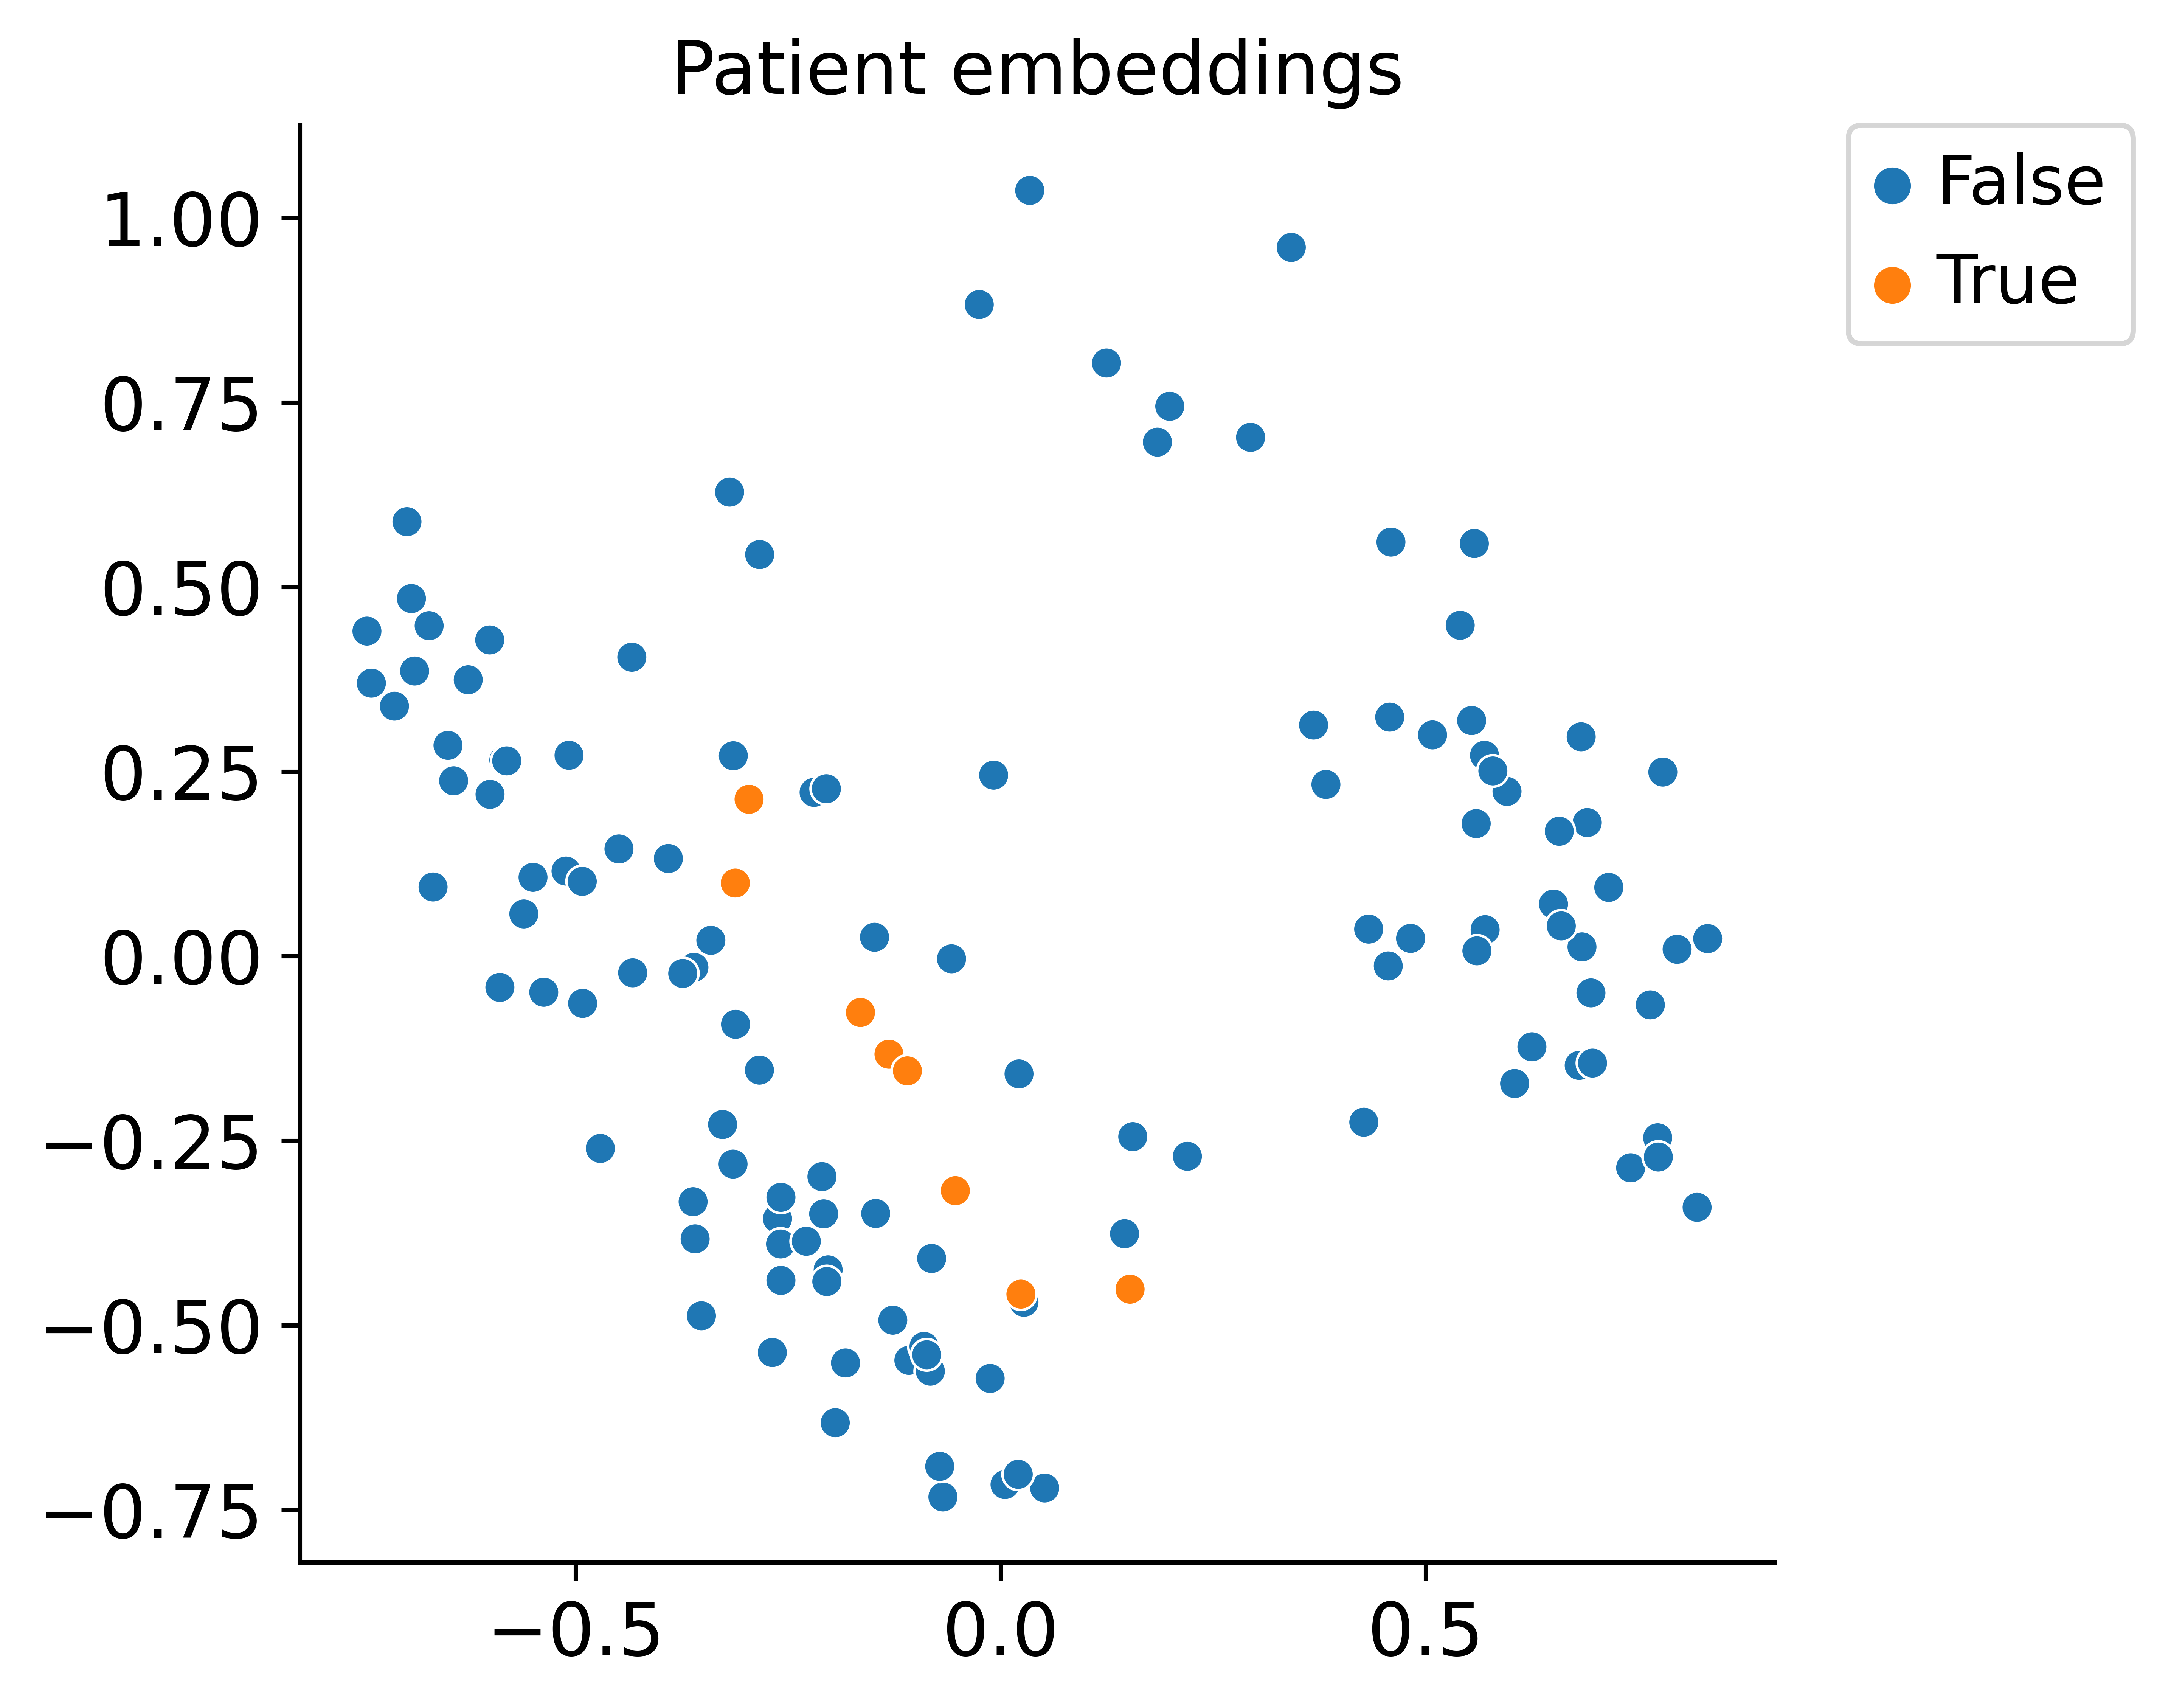

In [45]:
from sklearn.decomposition import KernelPCA

plot_key = 'query'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
patient_id = lataq_query.conditions_

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    #hue_order = cond_to_keep,
    #palette = 'Reds',
    ax=ax
)

#for i in range(emb_pca.shape[0]):
#    ax.text(
#        x=emb_pca[i, 0]+0.01,
#        y=emb_pca[i, 1]+0.01,
#        s=patient_id[i],
#        fontsize=5
#    )
ax.grid(False)
ax.set_title('Patient embeddings')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
fig.savefig('../figures/haniffa_embeddings_query.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


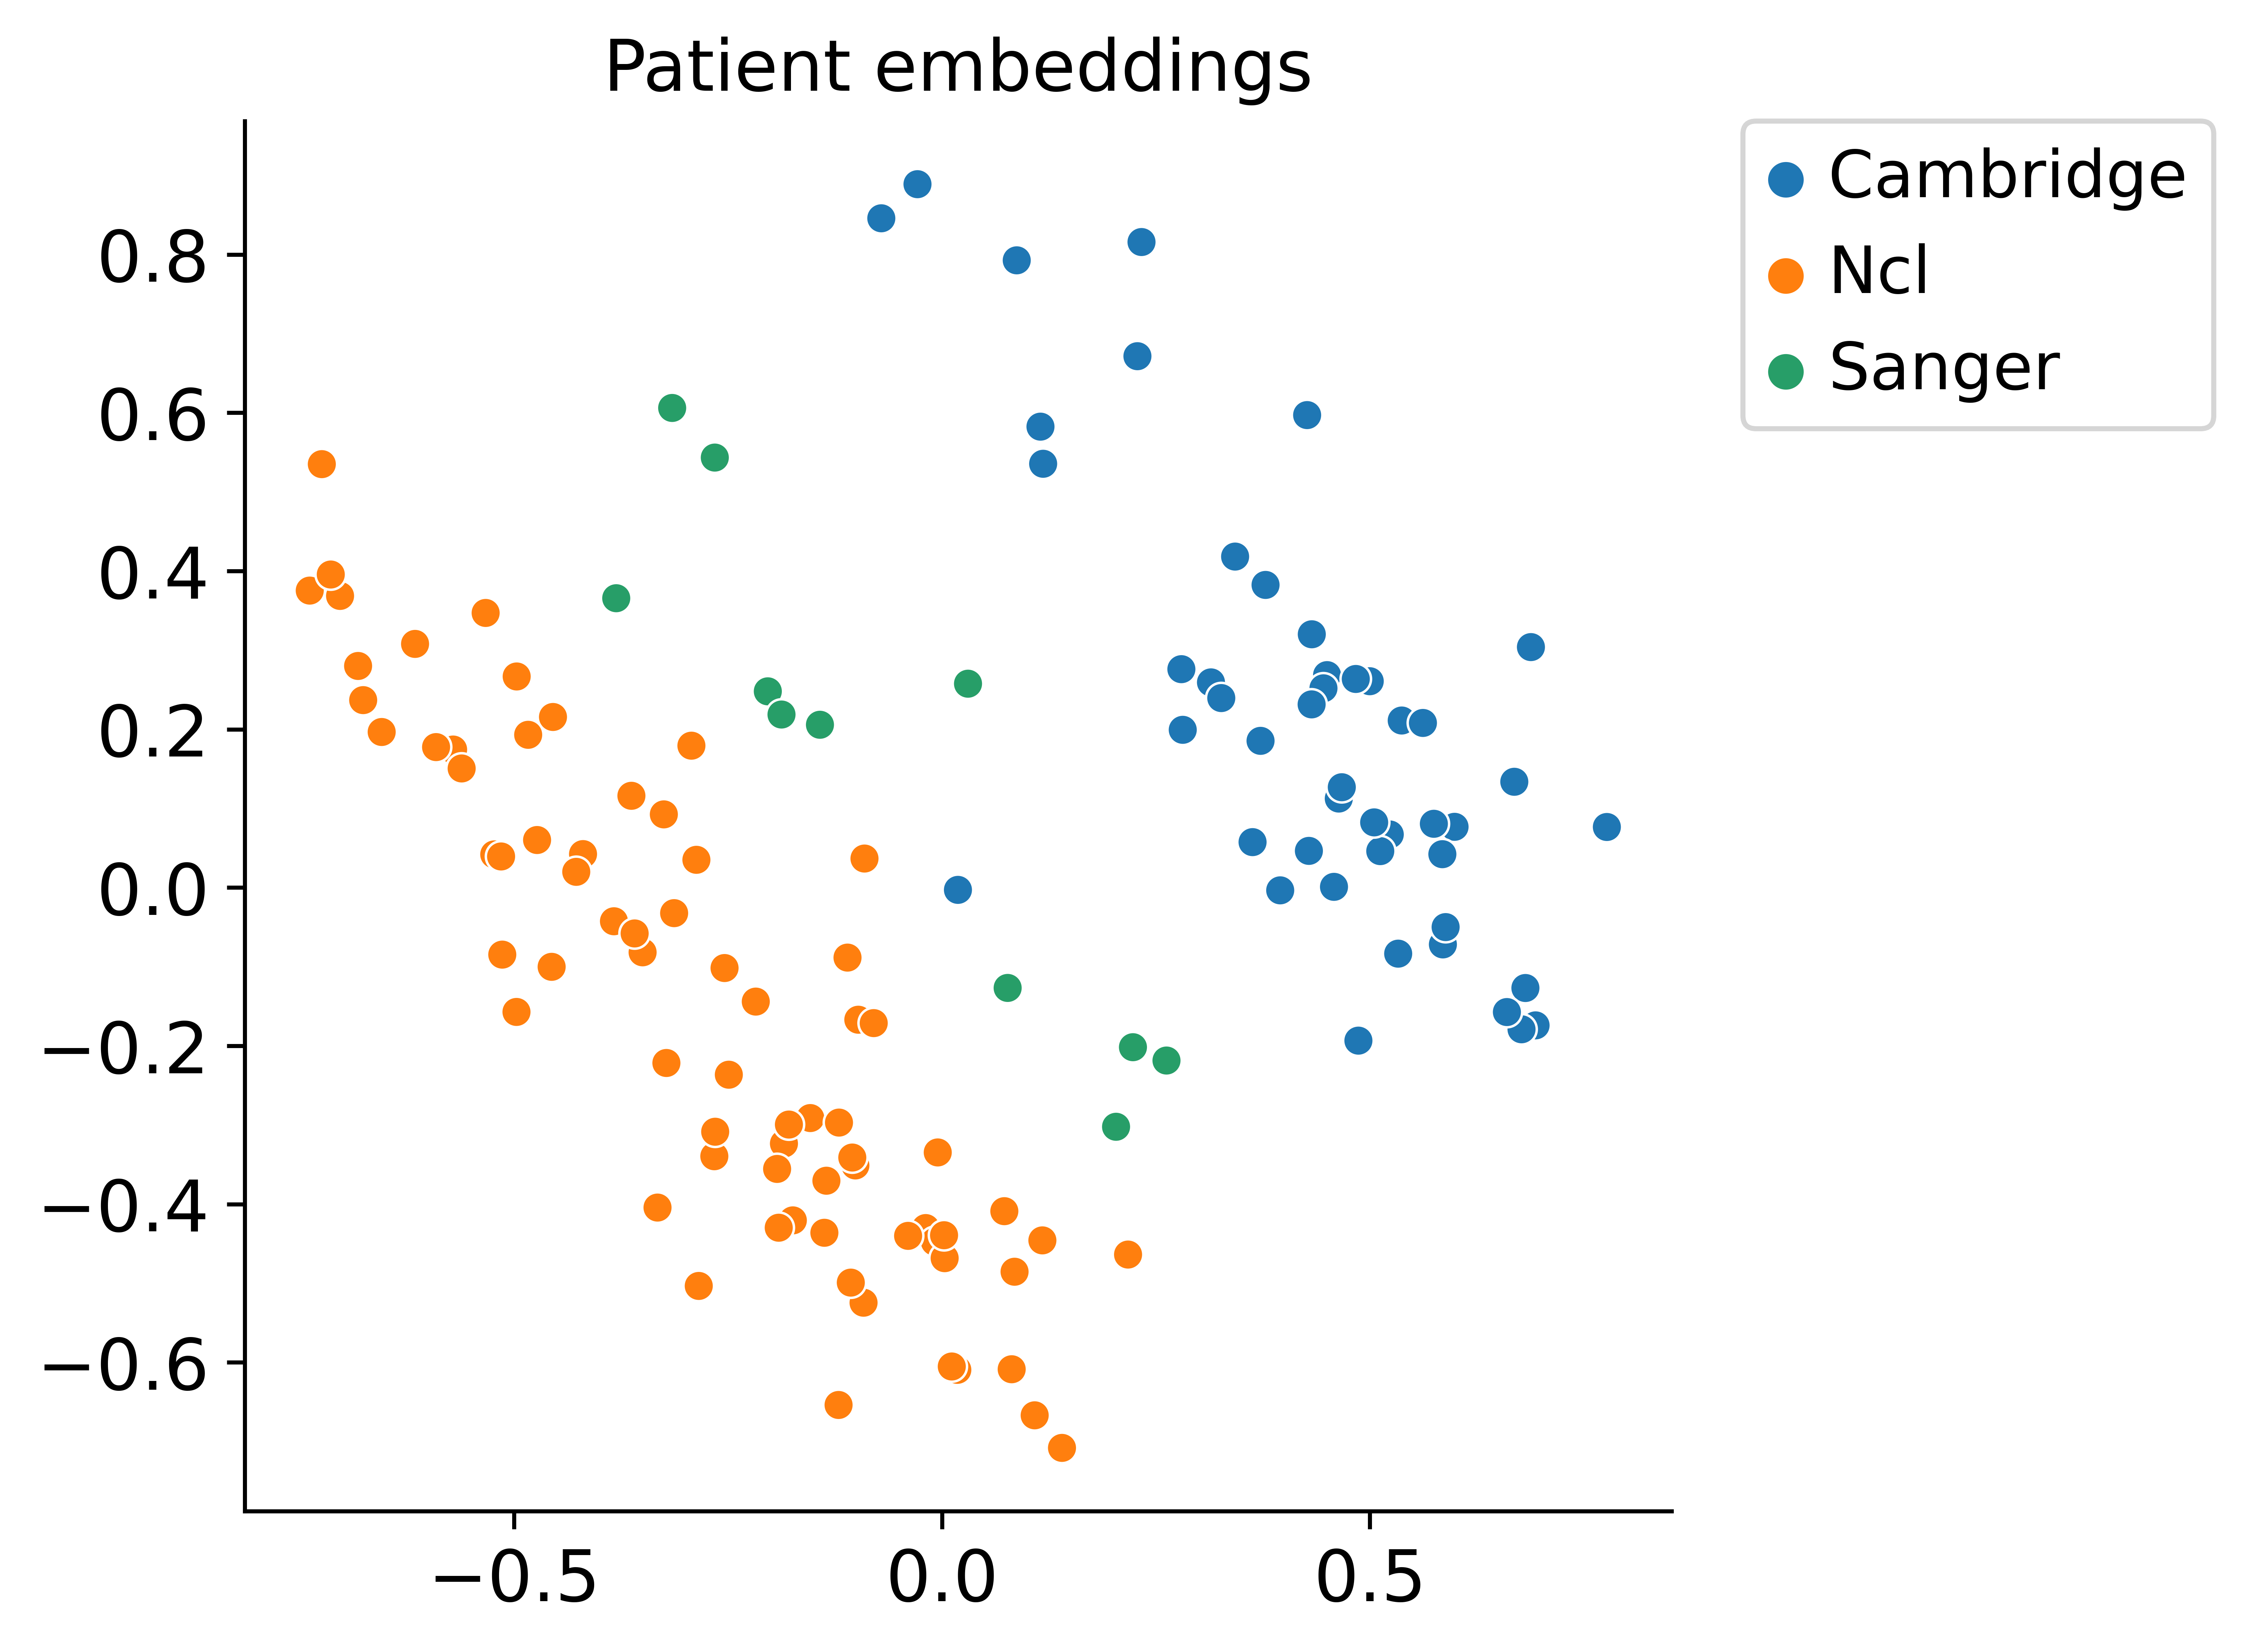

In [44]:
from sklearn.decomposition import KernelPCA

plot_key = 'Site'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='linear')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
patient_id = lataq_query.conditions_

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    #hue_order = cond_to_keep,
    #palette = 'Reds',
    ax=ax
)

#for i in range(emb_pca.shape[0]):
#    ax.text(
#        x=emb_pca[i, 0]+0.01,
#        y=emb_pca[i, 1]+0.01,
#        s=patient_id[i],
#        fontsize=5
#    )
ax.grid(False)
ax.set_title('Patient embeddings')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
fig.savefig('../figures/haniffa_embeddings_site.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


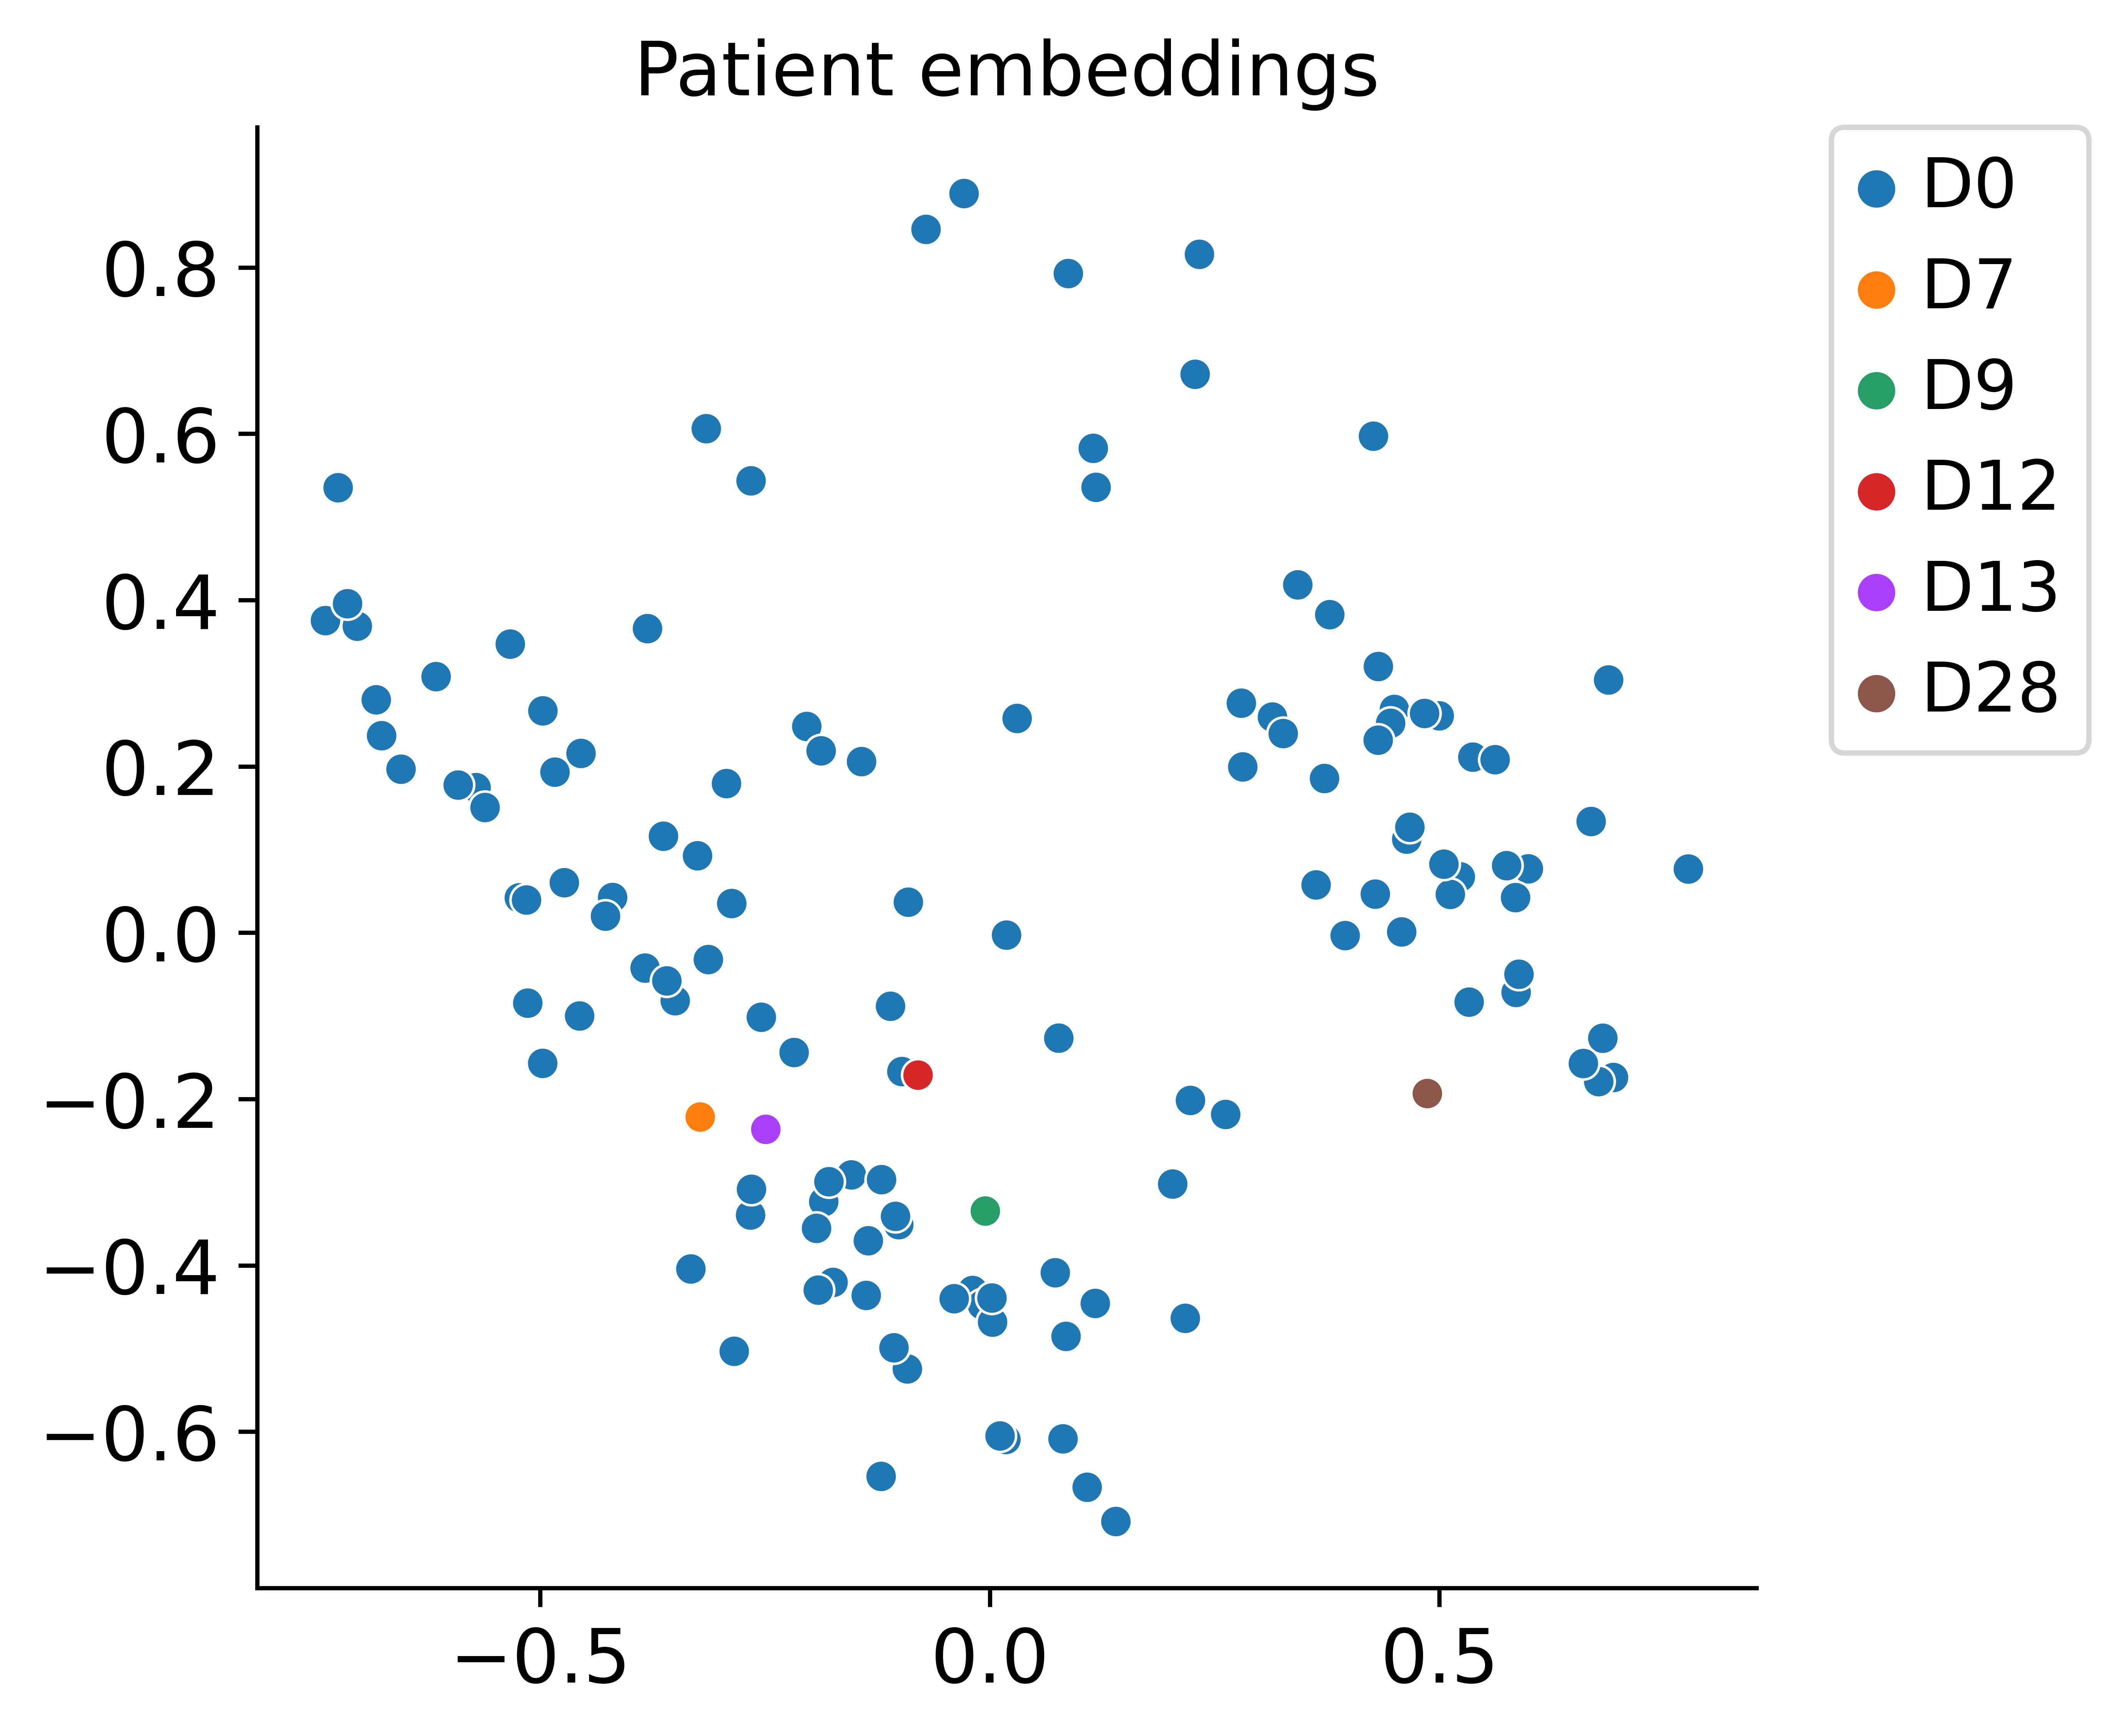

In [50]:
from sklearn.decomposition import KernelPCA

plot_key = 'Collection_Day'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='linear')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
patient_id = lataq_query.conditions_

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    #hue_order = cond_to_keep,
    #palette = 'Reds',
    ax=ax
)

#for i in range(emb_pca.shape[0]):
#    ax.text(
#        x=emb_pca[i, 0]+0.01,
#        y=emb_pca[i, 1]+0.01,
#        s=patient_id[i],
#        fontsize=5
#    )
ax.grid(False)
ax.set_title('Patient embeddings')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
fig.savefig('../figures/haniffa_embeddings_site.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


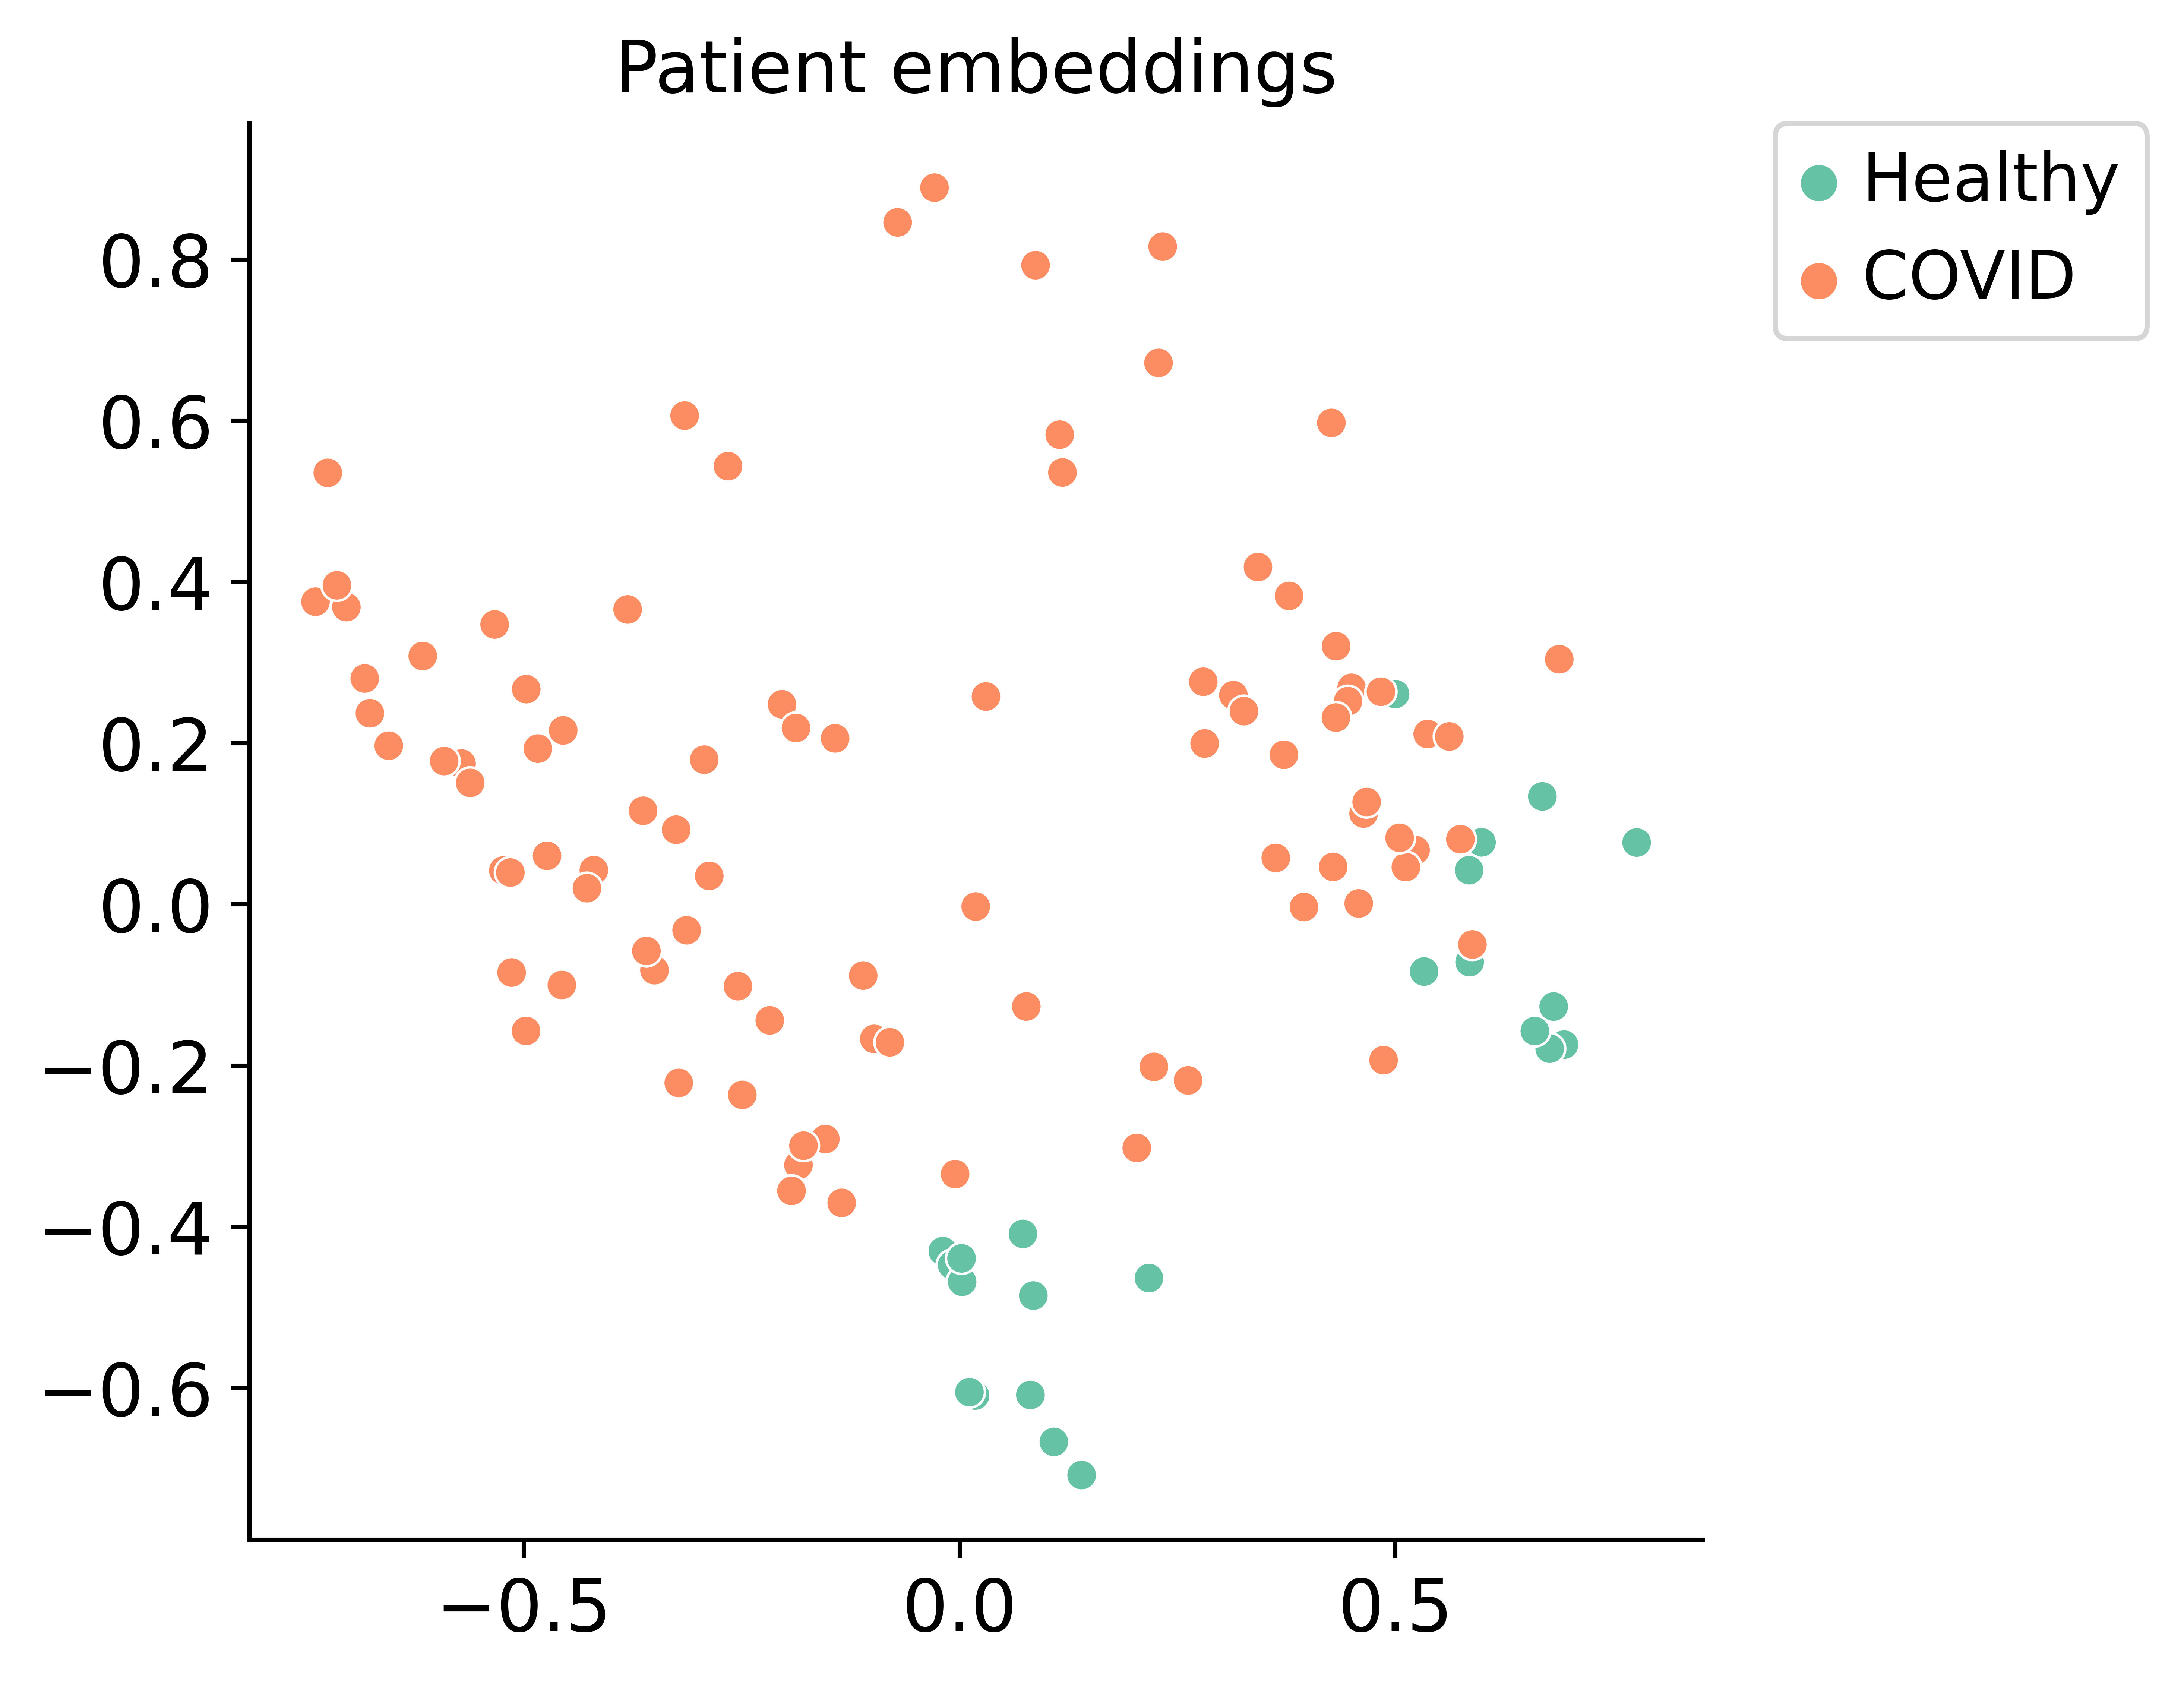

In [42]:
from sklearn.decomposition import KernelPCA

plot_key = 'Status_on_day_collection_summary'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='linear')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
patient_id = lataq_query.conditions_
cond_to_keep = ['Healthy', "Asymptomatic", "Moderate", "Mild", "Severe", "Critical"]
emb_pca = emb_pca[cond.isin(cond_to_keep), :]
cond = cond[cond.isin(cond_to_keep)].astype('str')
cond[cond!='Healthy'] = 'COVID'
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    #hue_order = cond_to_keep,
    palette = 'Set2',
    ax=ax
)

ax.grid(False)
ax.set_title('Patient embeddings')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
#fig.savefig('../figures/haniffa_embeddings_status.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


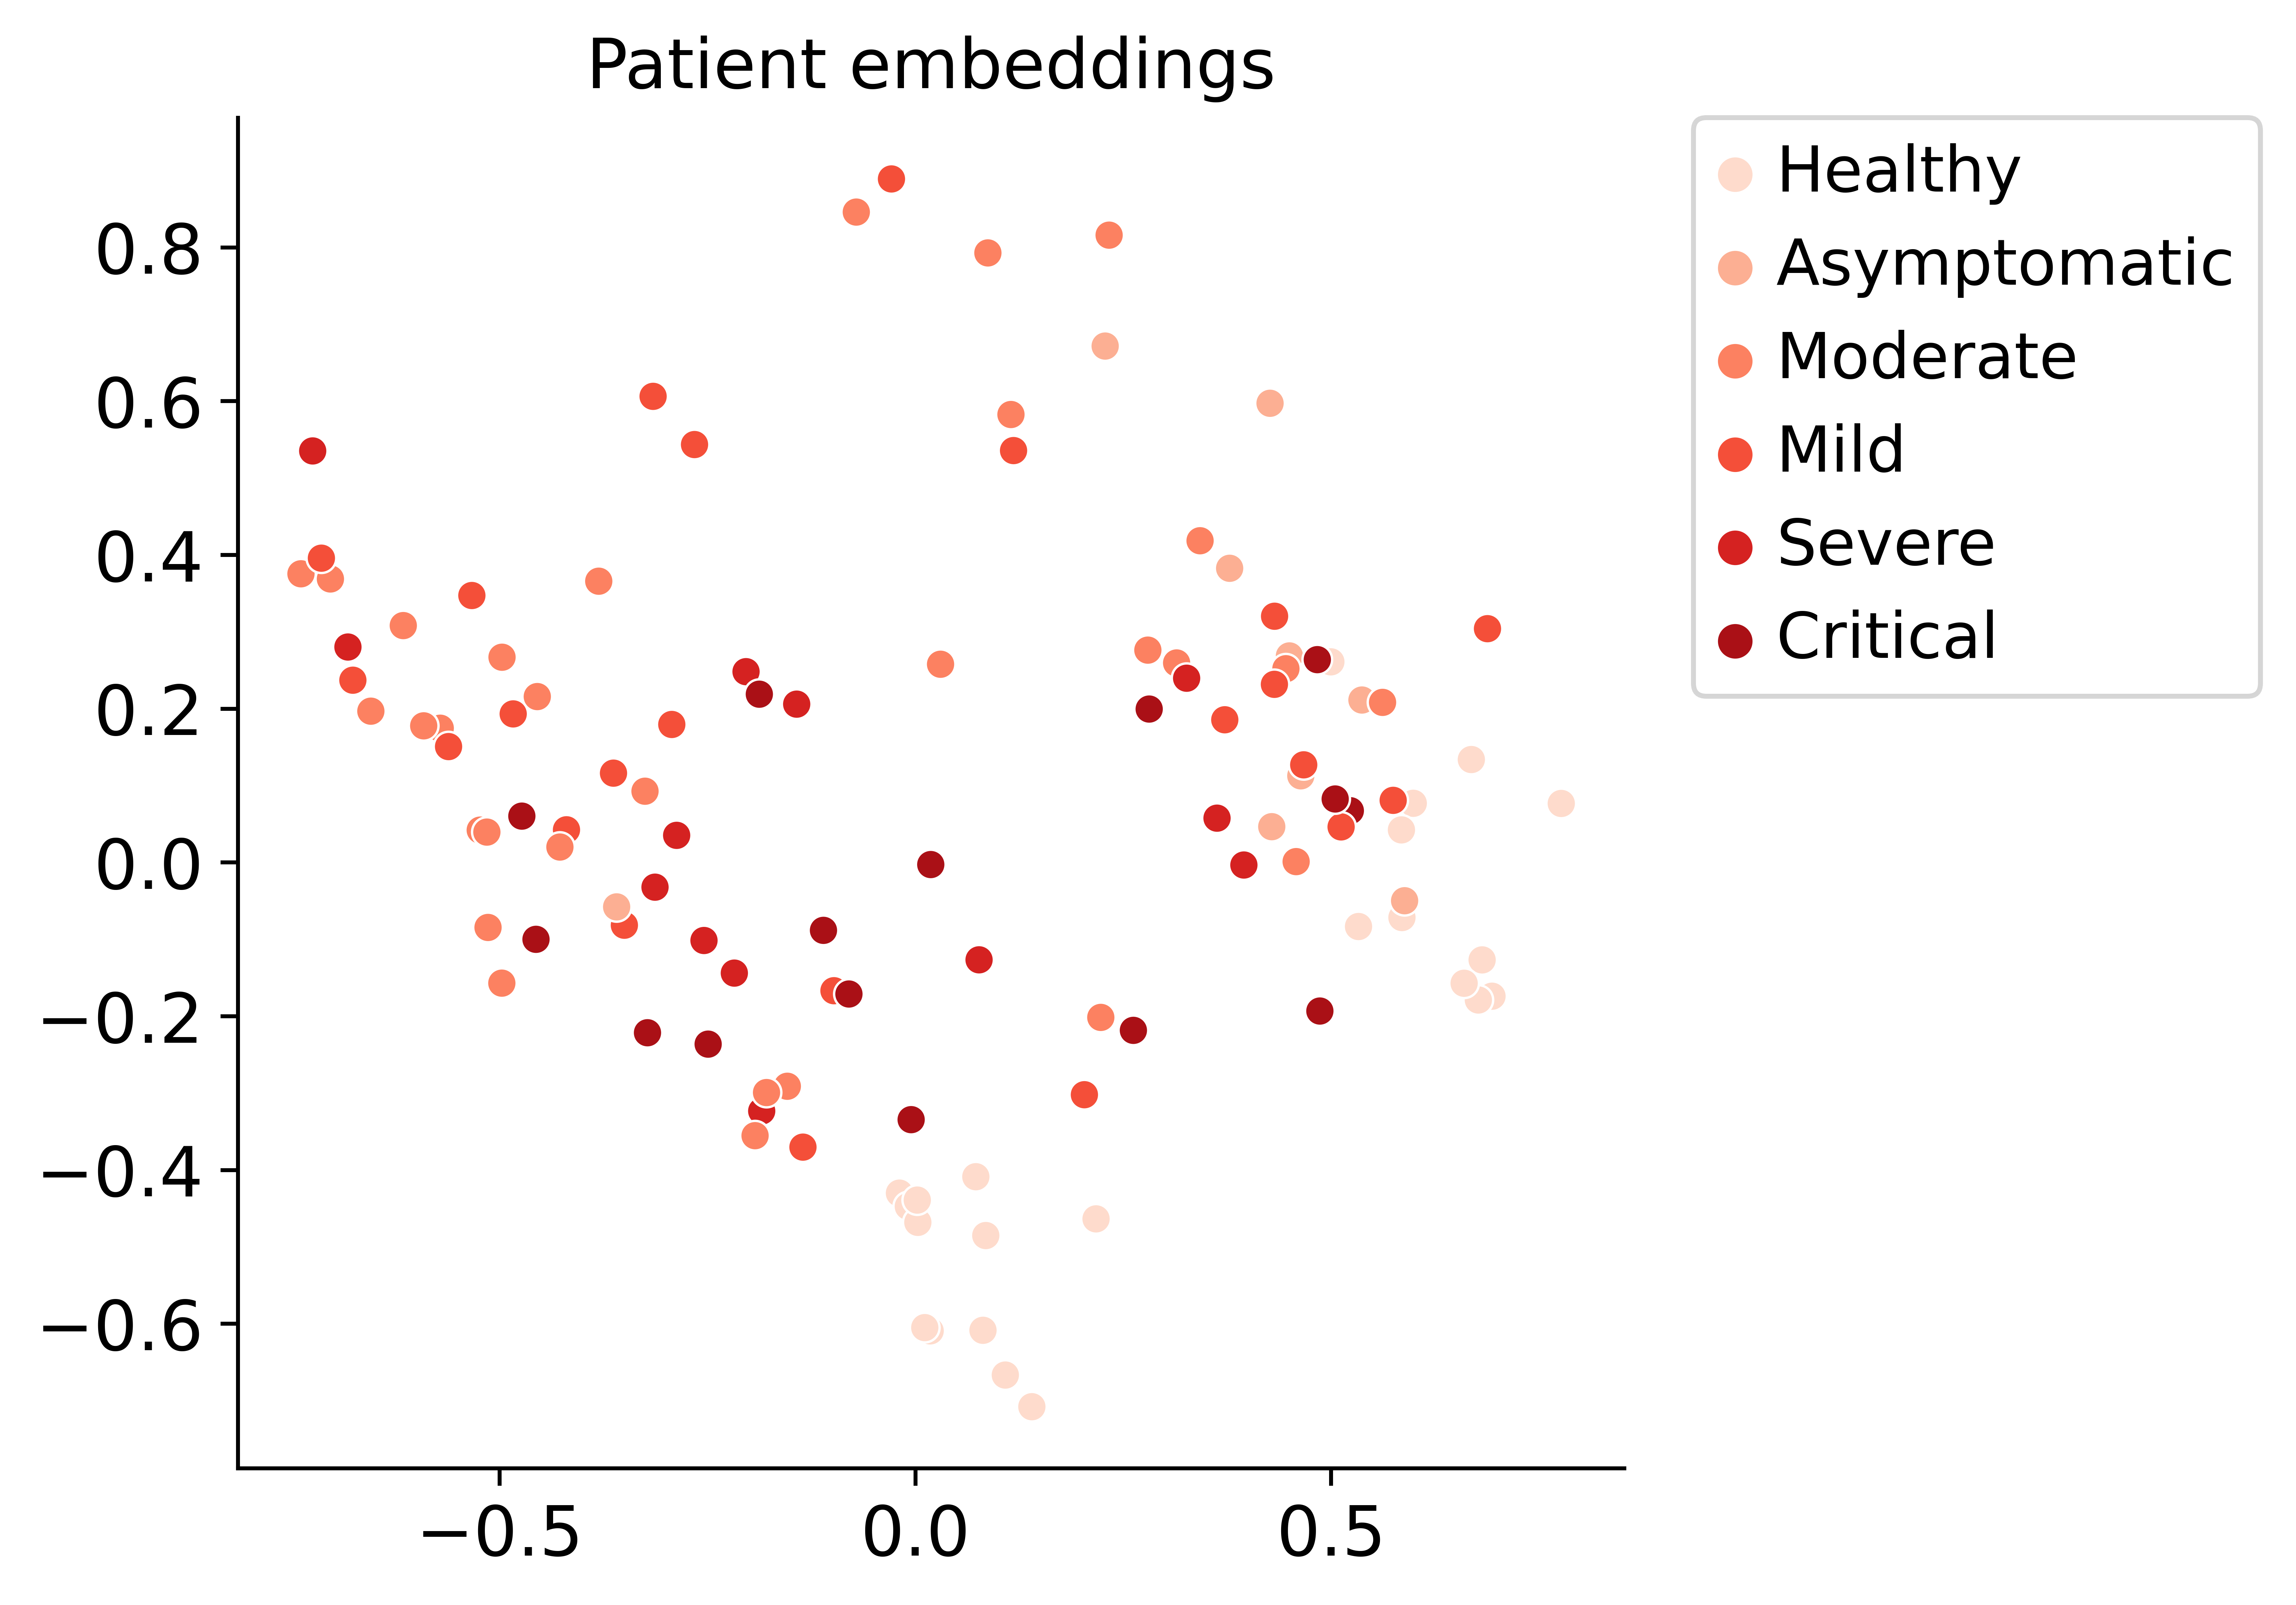

In [43]:
from sklearn.decomposition import KernelPCA

plot_key = 'Status_on_day_collection_summary'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='linear')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
patient_id = lataq_query.conditions_
cond_to_keep = ['Healthy', "Asymptomatic", "Moderate", "Mild", "Severe", "Critical"]
emb_pca = emb_pca[cond.isin(cond_to_keep), :]
cond = cond[cond.isin(cond_to_keep)].astype('str')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    hue_order = cond_to_keep,
    palette = 'Reds',
    ax=ax
)

ax.grid(False)
ax.set_title('Patient embeddings')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
fig.savefig('../figures/haniffa_embeddings_status_cont.png', dpi=600, bbox_inches='tight')

In [24]:
adata.obs.columns

Index(['sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'full_clustering',
       'initial_clustering', 'Resample', 'Collection_Day', 'Sex',
       'Age_interval', 'Swab_result', 'Status', 'Smoker',
       'Status_on_day_collection', 'Status_on_day_collection_summary',
       'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status',
       'Outcome', 'patient_id', 'batch', 'query'],
      dtype='object')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


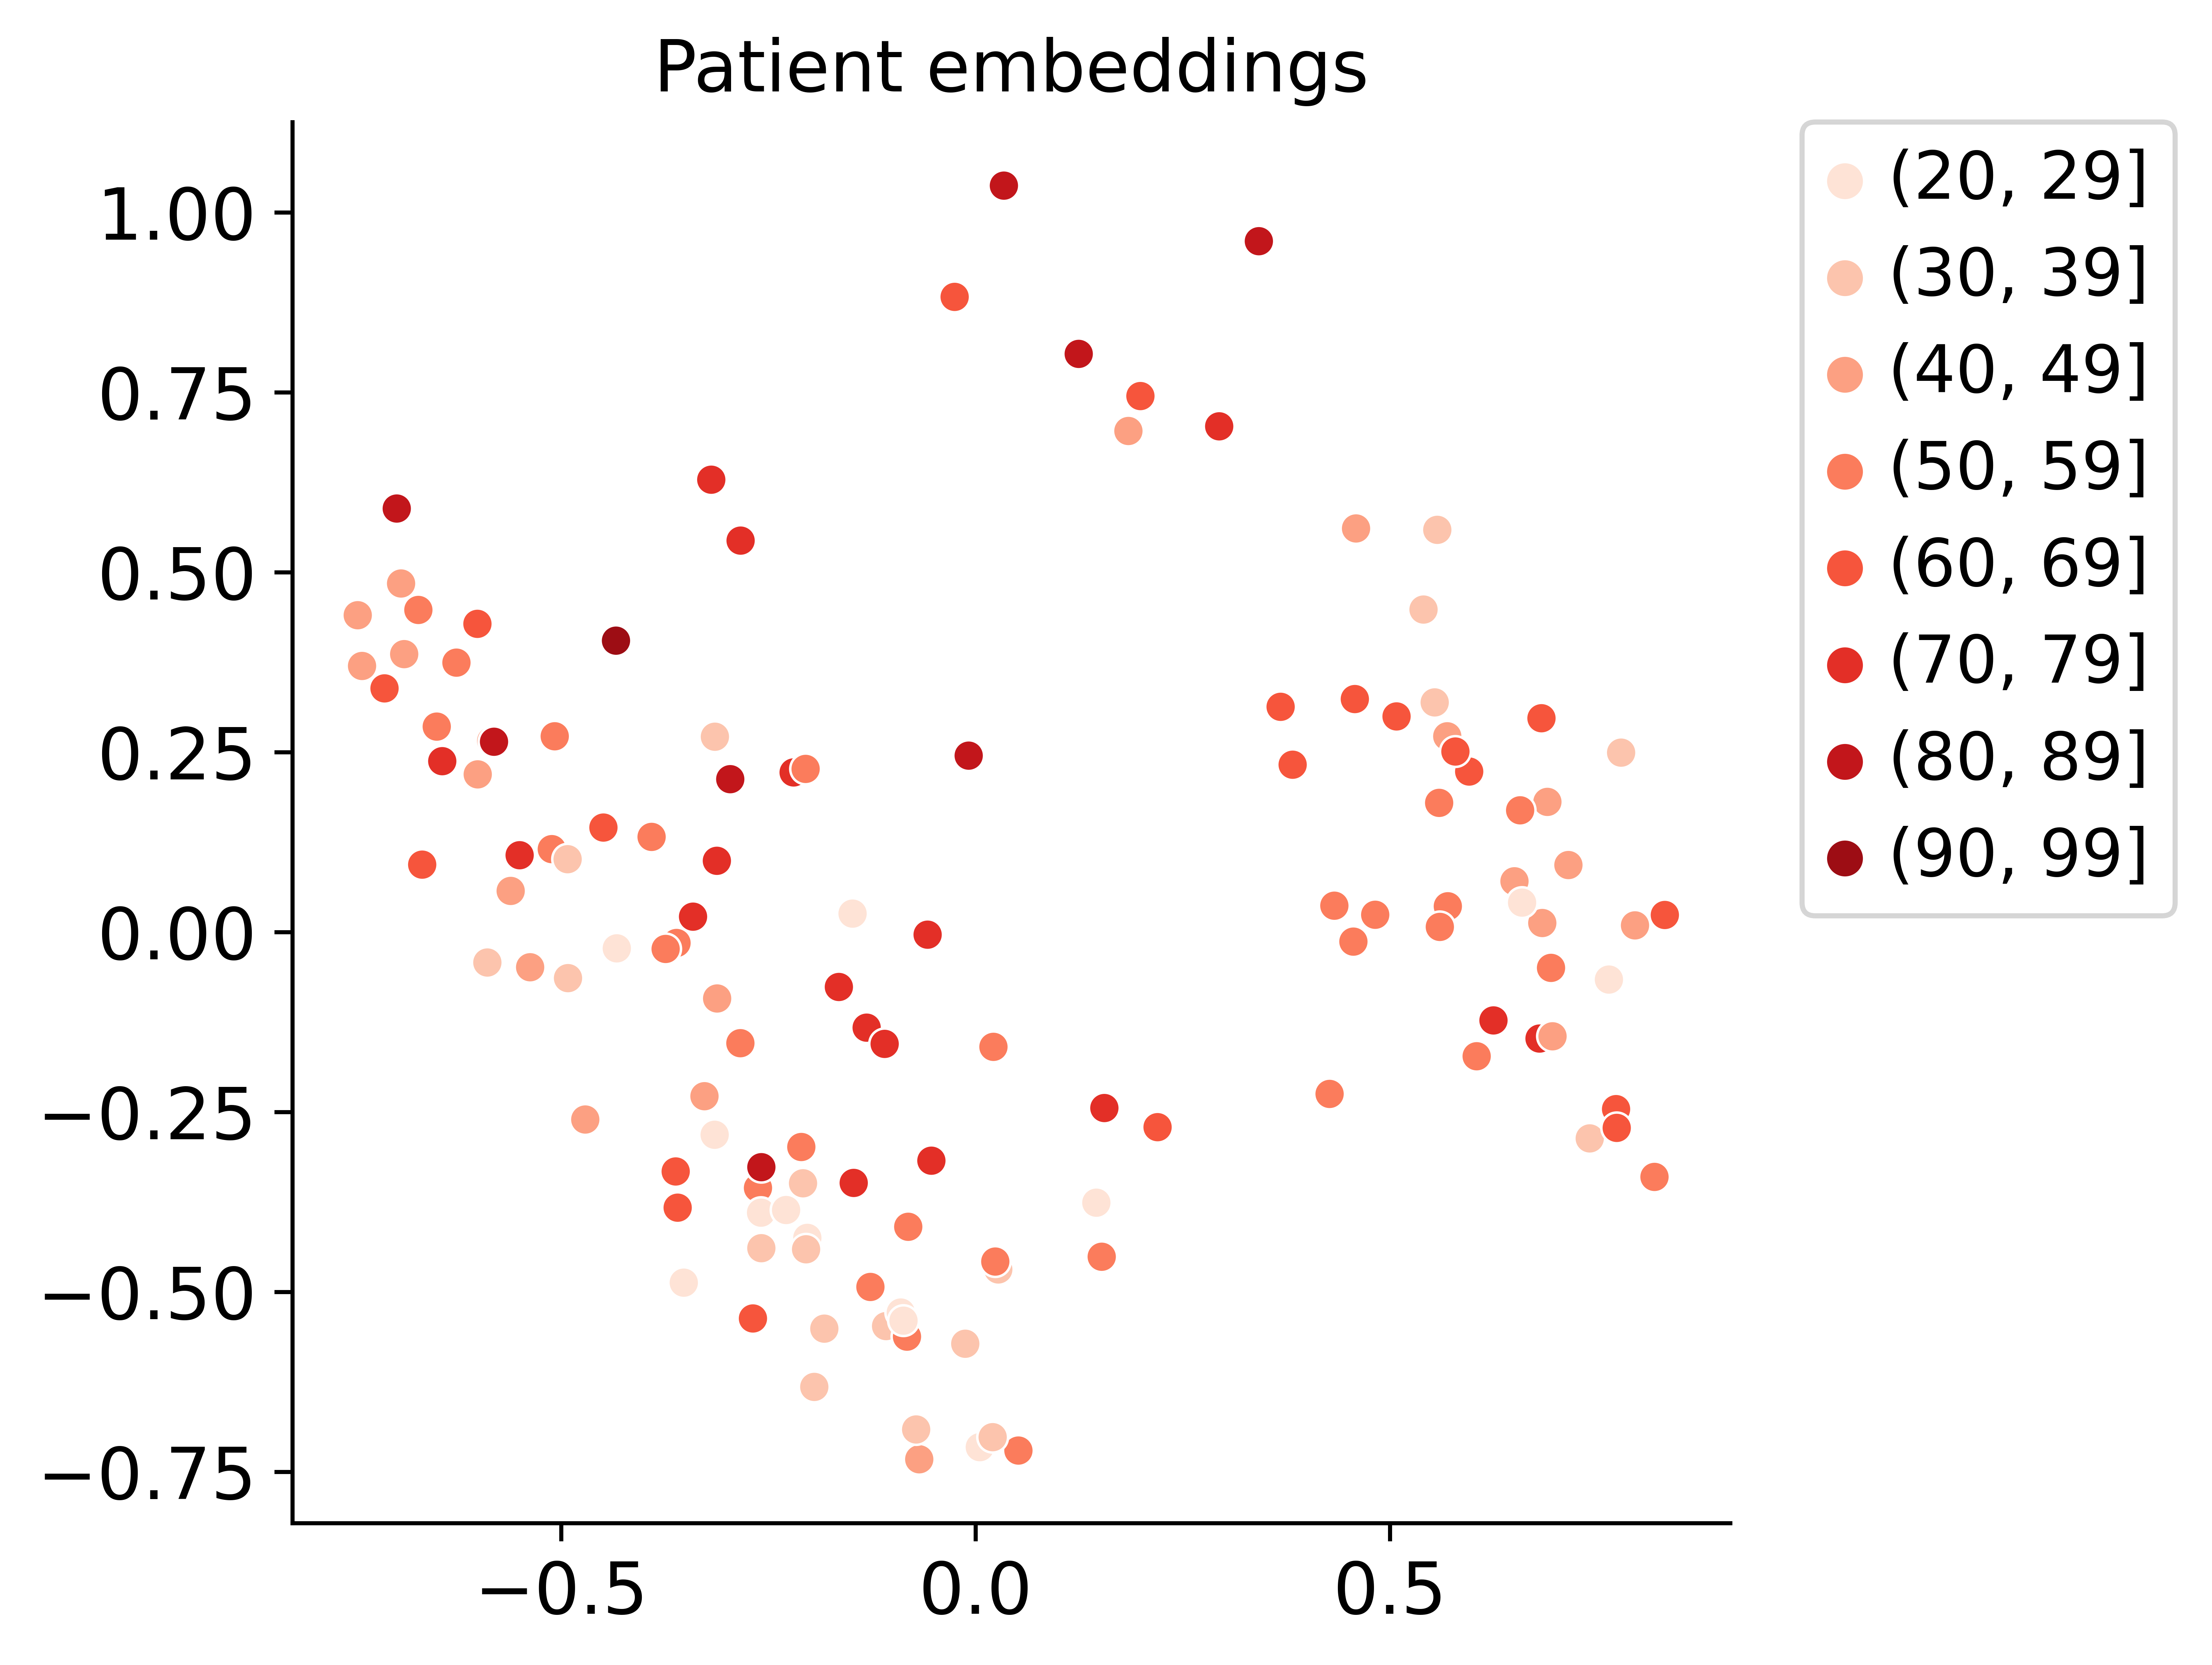

In [25]:
from sklearn.decomposition import KernelPCA

plot_key = 'Age_interval'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
patient_id = lataq_query.conditions_

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    #hue_order = cond_to_keep,
    palette = 'Reds',
    ax=ax
)

#for i in range(emb_pca.shape[0]):
#    ax.text(
#        x=emb_pca[i, 0]+0.01,
#        y=emb_pca[i, 1]+0.01,
#        s=patient_id[i],
#        fontsize=5
#    )
ax.grid(False)
ax.set_title('Patient embeddings')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
fig.savefig('../figures/haniffa_embeddings_age.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


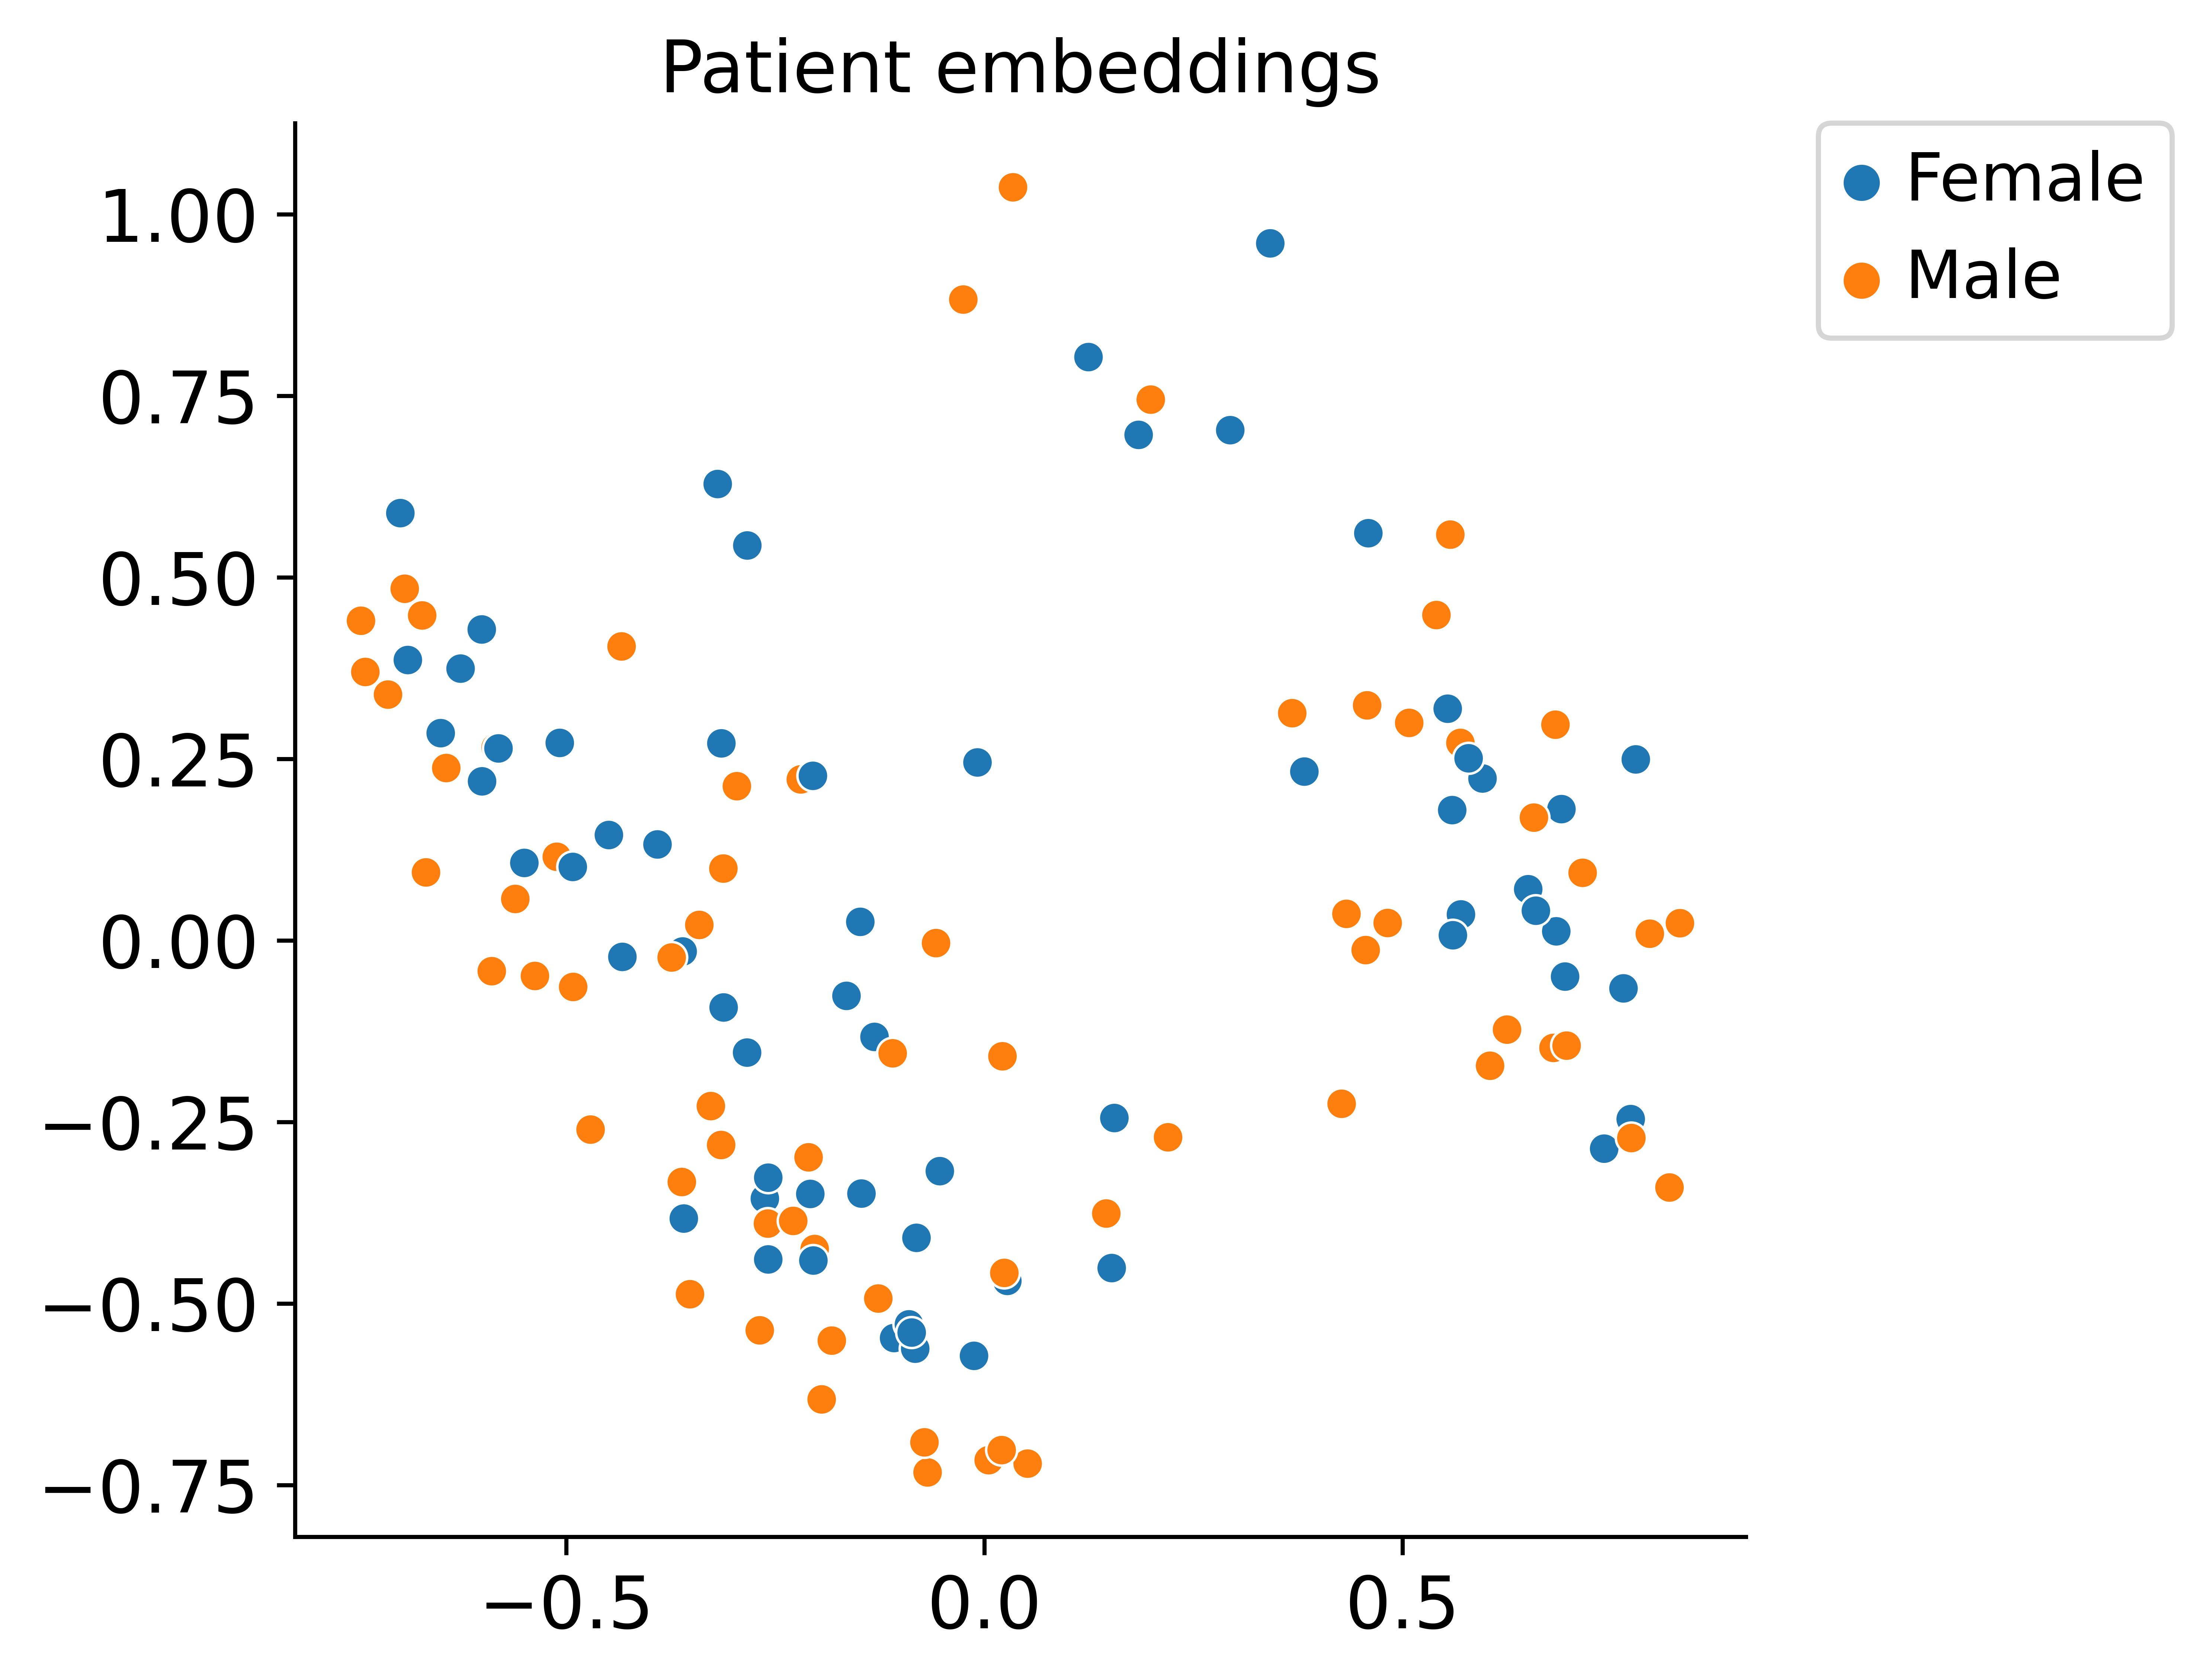

In [26]:
from sklearn.decomposition import KernelPCA

plot_key = 'Sex'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
patient_id = lataq_query.conditions_

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    #hue_order = cond_to_keep,
    ax=ax
)

#for i in range(emb_pca.shape[0]):
#    ax.text(
#        x=emb_pca[i, 0]+0.01,
#        y=emb_pca[i, 1]+0.01,
#        s=patient_id[i],
#        fontsize=5
#    )
ax.grid(False)
ax.set_title('Patient embeddings')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
fig.savefig('../figures/haniffa_embeddings_sex.png', dpi=600, bbox_inches='tight')

In [27]:
emb_anndata = sc.AnnData(
    X=embedding,
    obs=(
        adata
        .obs
        .groupby(condition_key)
        .first()
        .reindex(lataq_query.conditions_)
    )
)
emb_anndata.obsm['X_pca'] = emb_pca

... storing 'kmeans3' as categorical


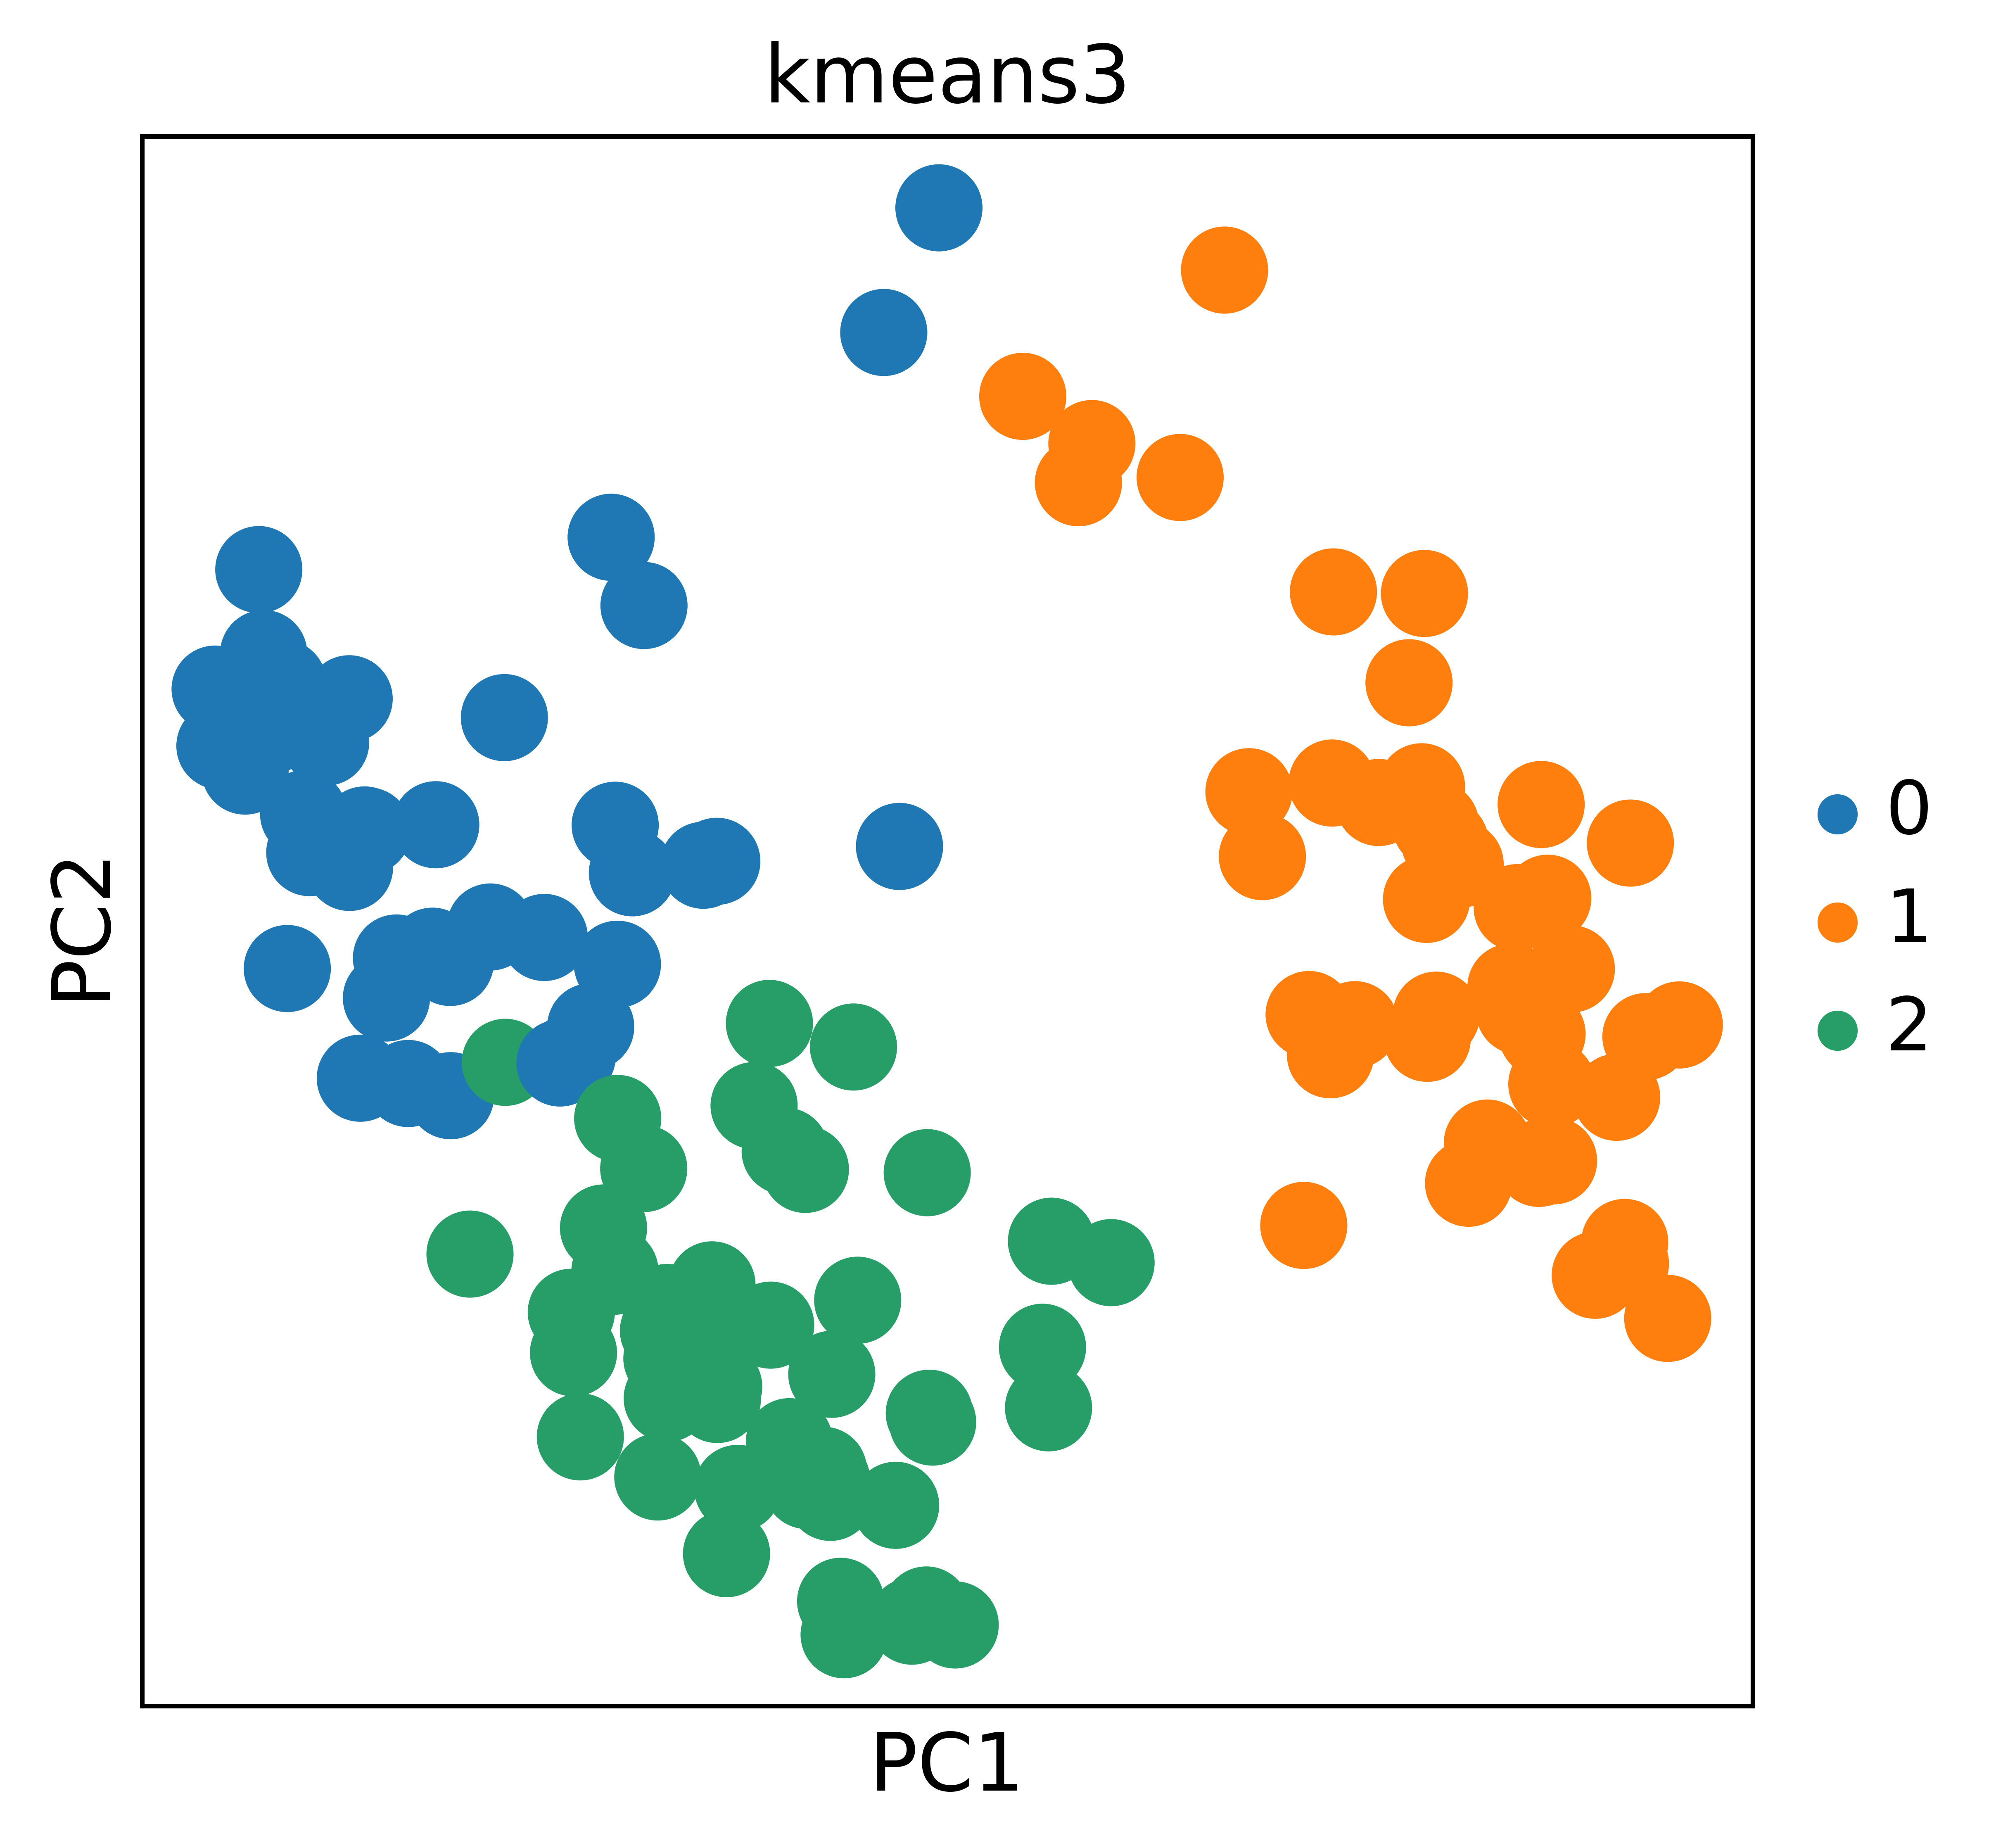

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# extract pca coordinates
X_pca = emb_anndata.X
# kmeans with k=5
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_pca) 
emb_anndata.obs['kmeans3'] = kmeans.labels_.astype(str)

sc.pl.pca(emb_anndata, color=['kmeans3'])

In [29]:
sc.pp.neighbors(emb_anndata, use_rep='X')
sc.tl.leiden(emb_anndata, resolution=0.5)

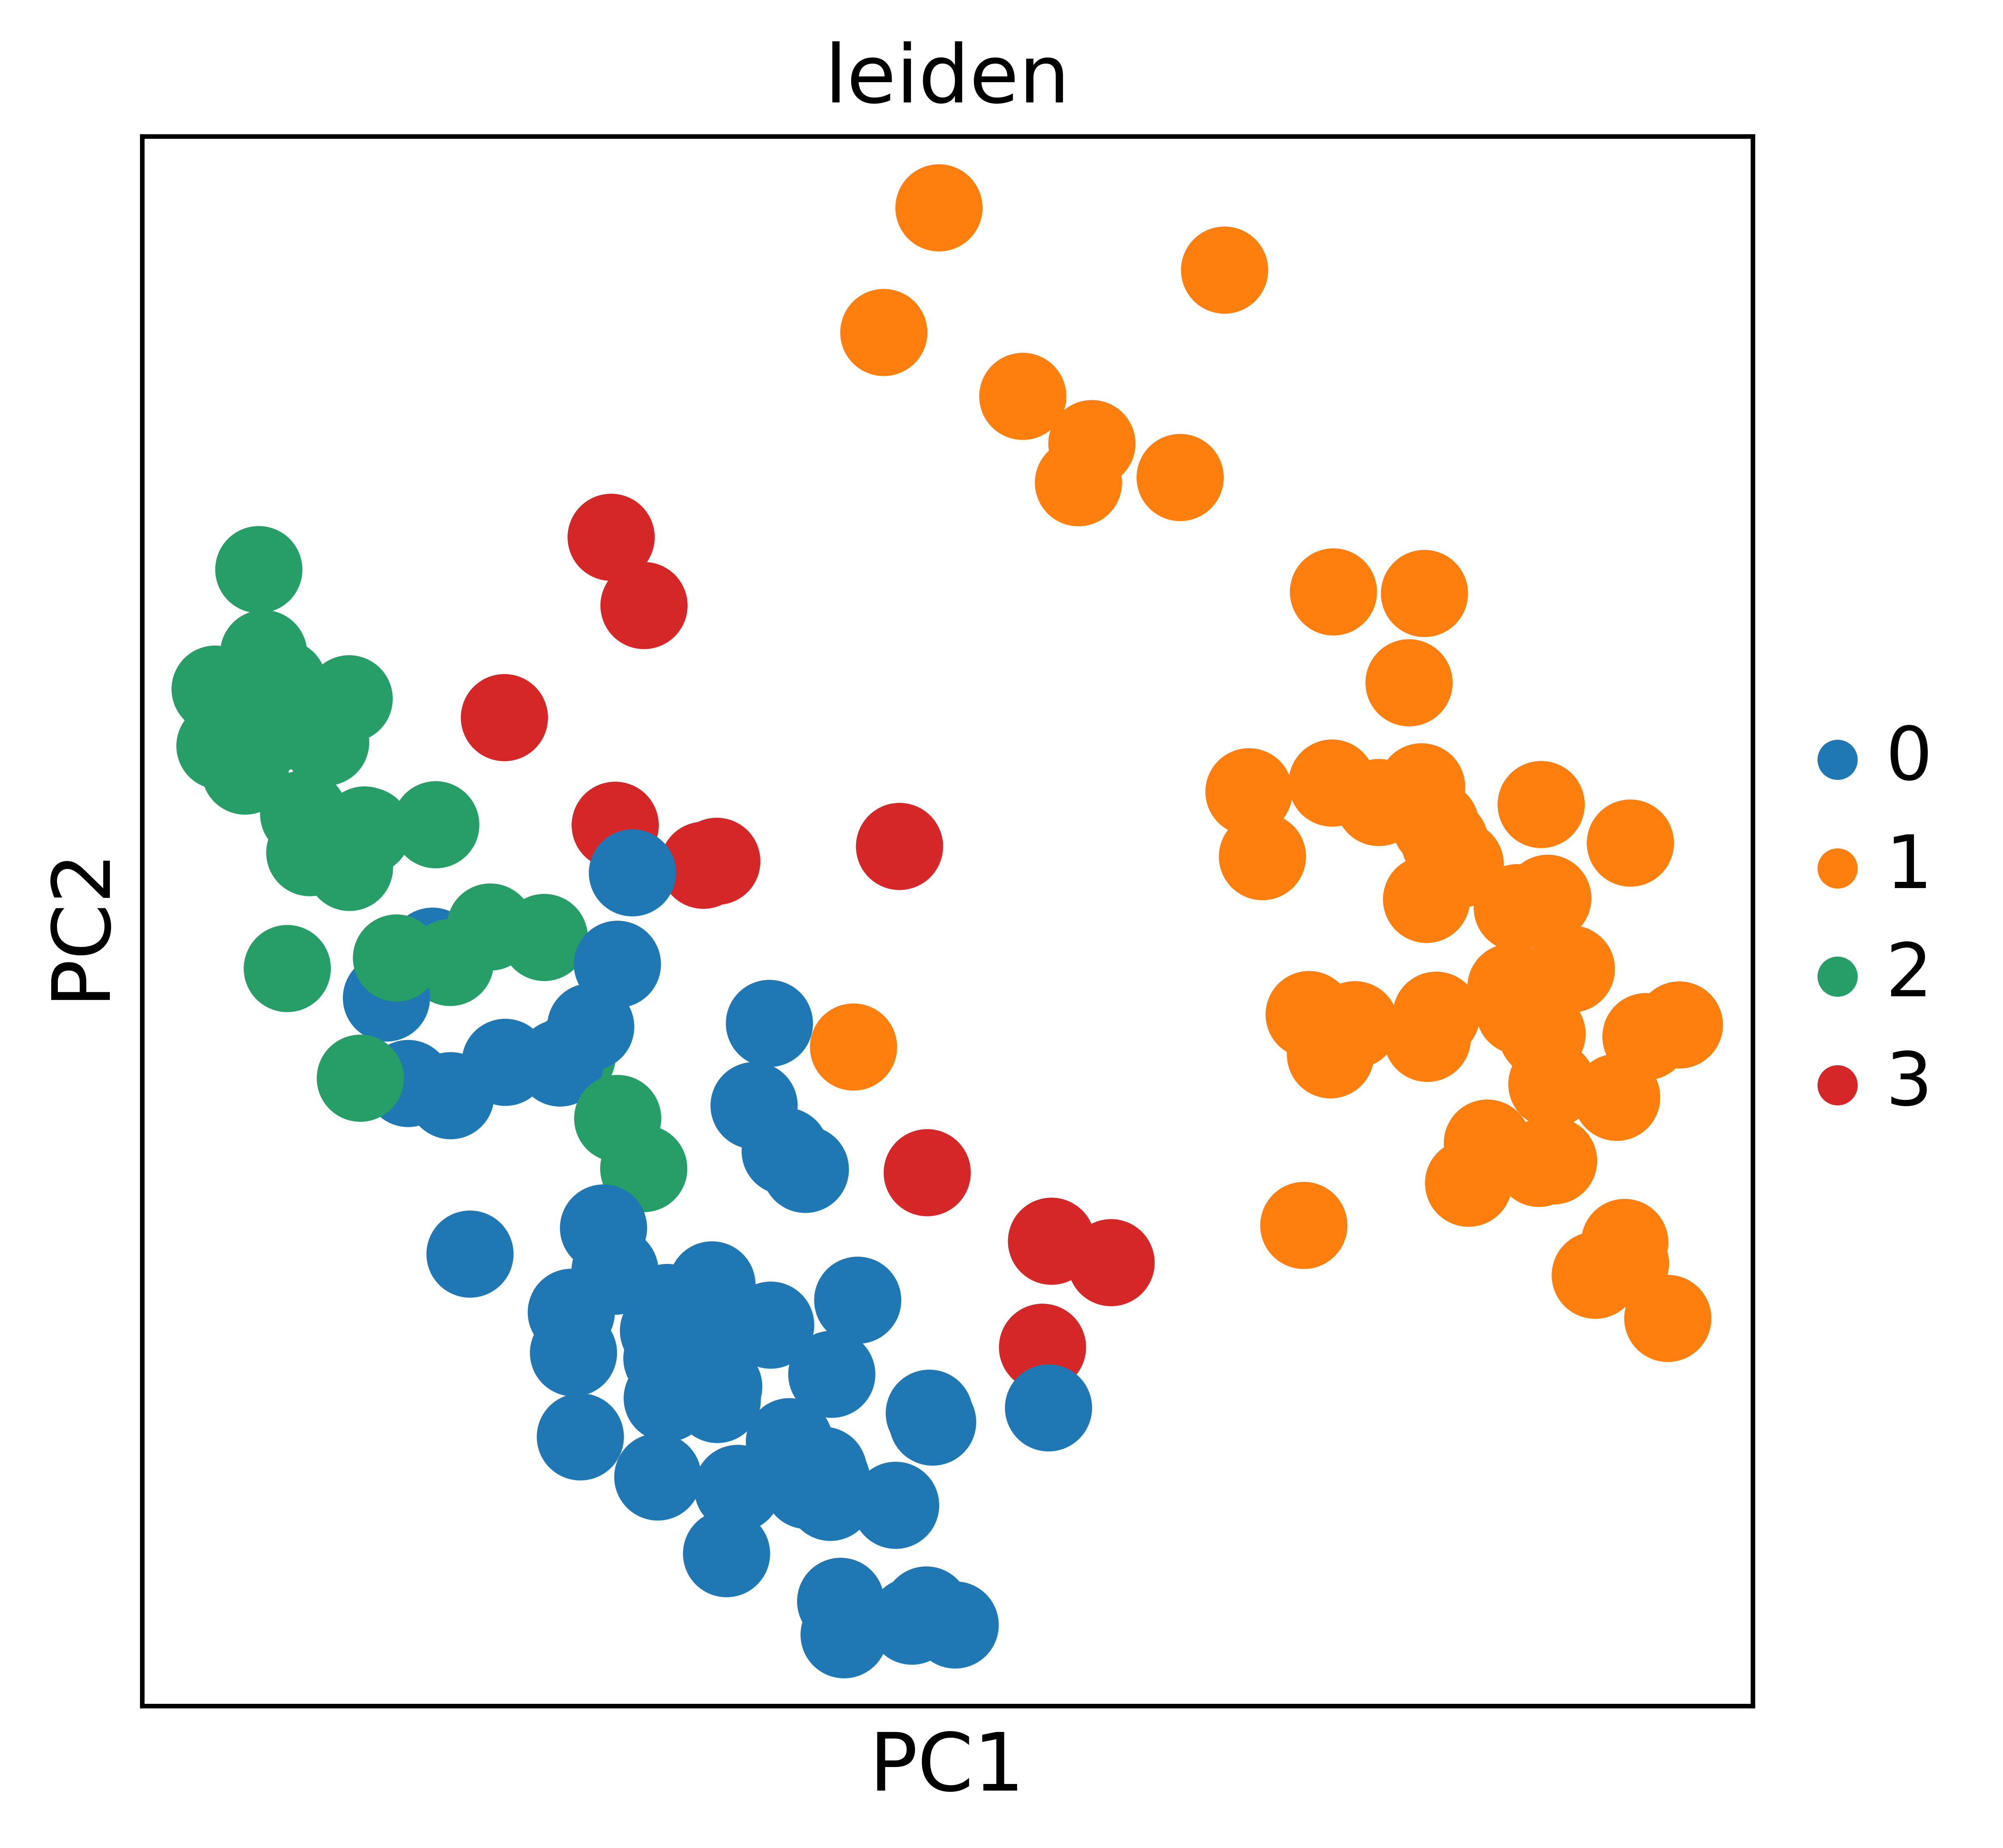

In [30]:
sc.pl.pca(emb_anndata, color='leiden')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


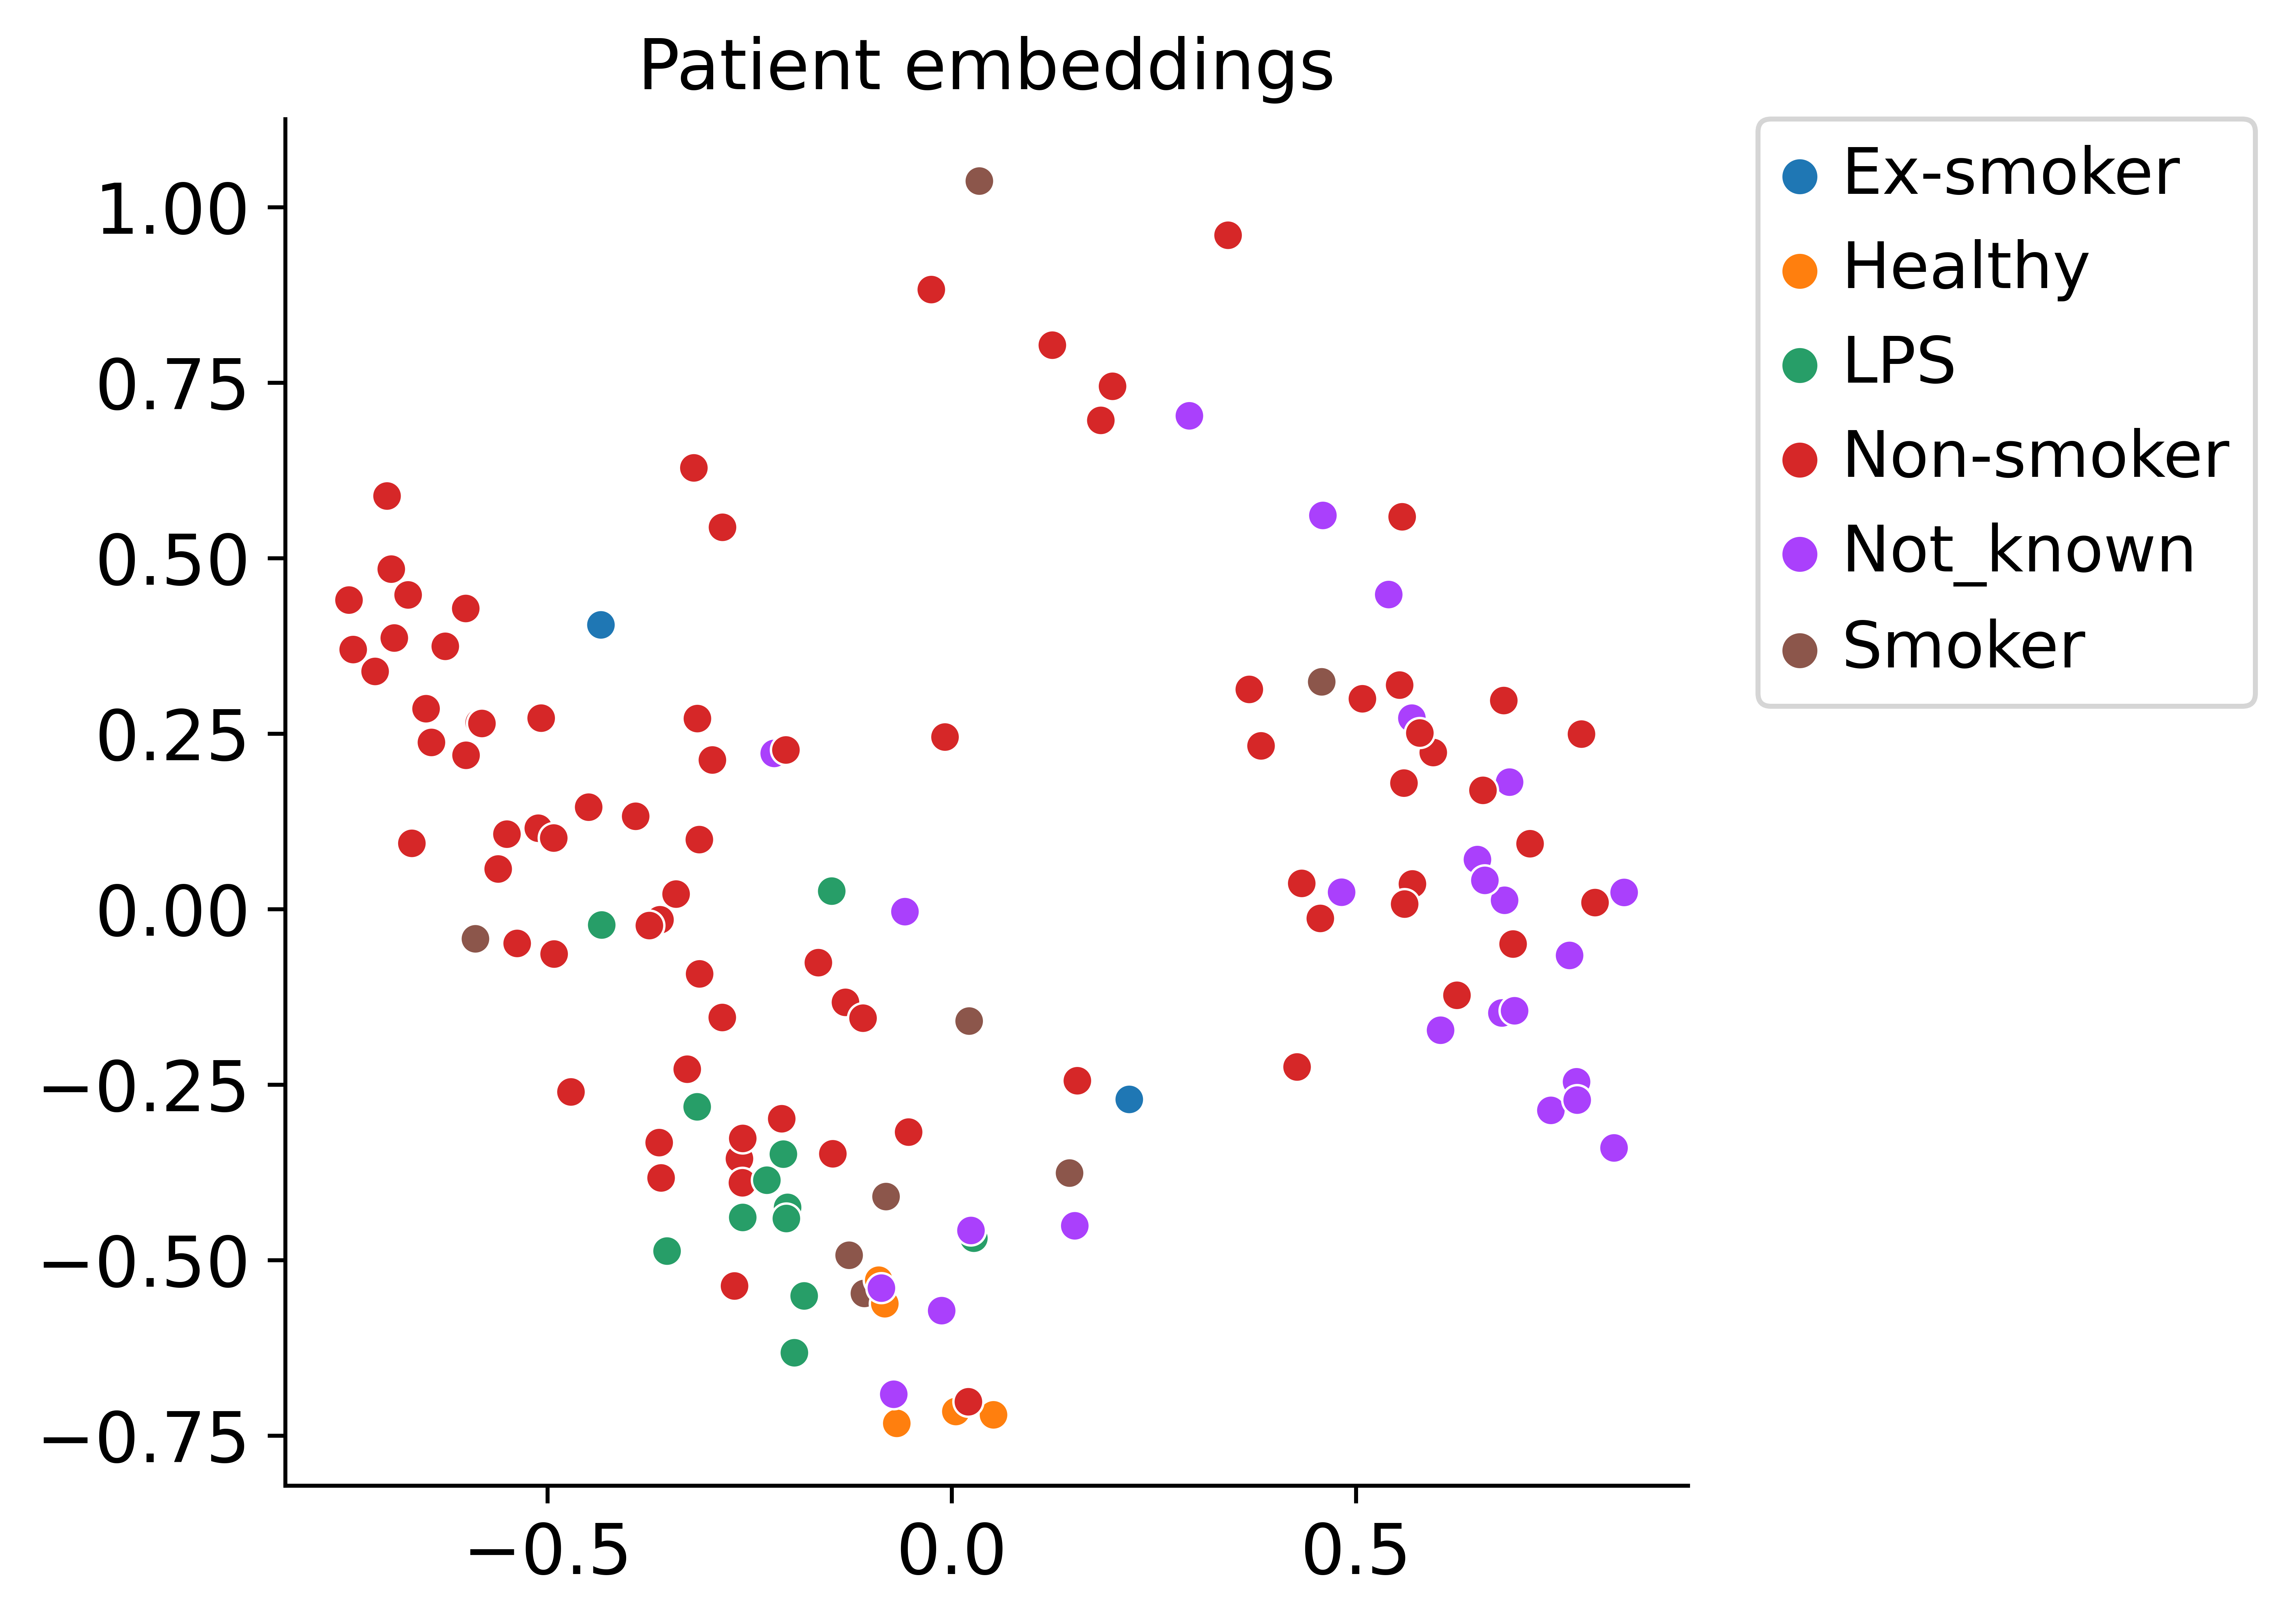

In [31]:
from sklearn.decomposition import KernelPCA

plot_key = 'Smoker'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
patient_id = lataq_query.conditions_

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    #hue_order = cond_to_keep,
    ax=ax
)

#for i in range(emb_pca.shape[0]):
#    ax.text(
#        x=emb_pca[i, 0]+0.01,
#        y=emb_pca[i, 1]+0.01,
#        s=patient_id[i],
#        fontsize=5
#    )
ax.grid(False)
ax.set_title('Patient embeddings')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
fig.savefig('../figures/haniffa_embeddings_smoker.png', dpi=600, bbox_inches='tight')

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
embedding = pd.DataFrame(
    lataq_query
    .model
    .embedding
    .weight
    .detach()
    .cpu()
    .numpy()
)
embedding.index = lataq_query.conditions_
col = (        
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    ['Site']
)

lut = dict(zip(col.unique(), "rbg"))
row_colors = col.map(lut)

sns.clustermap(
    embedding, 
    row_colors=row_colors,
    metric='cosine',
    vmin=-1,
    vmax=1,
)

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

In [34]:
key = 'Status_on_day_collection_summary'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)
is_query = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    ['query']
)
cond_to_keep = ['Healthy', "Asymptomatic", "Moderate", "Mild", "Severe", "Critical"]
emb_pca = emb_pca[cond.isin(cond_to_keep), :]
is_query = is_query[cond.isin(cond_to_keep)].astype(bool)
cond = cond[cond.isin(cond_to_keep)].astype('str')
cond[cond!='Healthy'] = 'COVID'

X = emb_pca
y = cond
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = emb_pca[~is_query]
y_train = cond[~is_query]
X_test = emb_pca[is_query]
y_test = cond[is_query]
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
print(neigh.score(X_test, y_test))
y_pred = neigh.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred
    )
)

0.875
              precision    recall  f1-score   support

       COVID       0.86      1.00      0.92         6
     Healthy       1.00      0.50      0.67         2

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8



In [35]:
key = 'Site'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)
is_query = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    ['query']
).astype(bool)

X = emb_pca
y = cond
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = emb_pca[~is_query]
y_train = cond[~is_query]
X_test = emb_pca[is_query]
y_test = cond[is_query]
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
print(neigh.score(X_test, y_test))
y_pred = neigh.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred
    )
)

0.75
              precision    recall  f1-score   support

         Ncl       1.00      0.75      0.86         8
      Sanger       0.00      0.00      0.00         0

    accuracy                           0.75         8
   macro avg       0.50      0.38      0.43         8
weighted avg       1.00      0.75      0.86         8



/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [36]:
scores=[]

key = 'Site'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)

X = embedding
y = cond
for i in np.arange(1, 10):
    neigh = SVC()
    cv_scores = cross_val_score(neigh, X, y, cv=5, scoring='accuracy')
    print(np.mean(cv_scores))
    scores.append(np.mean(cv_scores))

0.9923076923076923
0.9923076923076923
0.9923076923076923
0.9923076923076923
0.9923076923076923
0.9923076923076923
0.9923076923076923
0.9923076923076923
0.9923076923076923


In [37]:
scores=[]

key = 'Status_on_day_collection_summary'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)

X = embedding
y = cond
for i in np.arange(1, 10):
    neigh = SVC()
    cv_scores = cross_val_score(neigh, X, y, cv=5, scoring='accuracy')
    print(np.mean(cv_scores))
    scores.append(np.mean(cv_scores))

0.43076923076923074
0.43076923076923074
0.43076923076923074
0.43076923076923074
0.43076923076923074
0.43076923076923074
0.43076923076923074
0.43076923076923074
0.43076923076923074


In [38]:
scores=[]

key = 'Status'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)

X = emb_pca
y = cond
for i in np.arange(1, 10):
    neigh = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(neigh, X, y, cv=5, scoring='accuracy')
    print(np.mean(cv_scores))
    scores.append(np.mean(cv_scores))

0.7076923076923076
0.7846153846153846
0.7307692307692306
0.7538461538461538
0.7692307692307693
0.7846153846153846
0.7461538461538462
0.7692307692307692
0.8


In [39]:
scores=[]

key = 'Site'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)

X = emb_pca
y = cond
for i in np.arange(1, 10):
    neigh = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(neigh, X, y, cv=5, scoring='accuracy')
    print(np.mean(cv_scores))
    scores.append(np.mean(cv_scores))

0.9307692307692308
0.9230769230769231
0.9384615384615383
0.9538461538461538
0.9384615384615385
0.9307692307692308
0.9153846153846154
0.9153846153846154
0.9153846153846154


In [40]:
scores=[]

embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)

X = emb_pca
y = cond
for i in np.arange(1, 10):
    neigh = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(neigh, X, y, cv=5, scoring='accuracy')
    print(np.mean(cv_scores))
    scores.append(np.mean(cv_scores))

0.9307692307692308
0.9230769230769231
0.9384615384615383
0.9538461538461538
0.9384615384615385
0.9307692307692308
0.9153846153846154
0.9153846153846154
0.9153846153846154
